In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "5"

In [1]:
from memflow.read_data.dataset_all import DatasetCombined
from memflow.unfolding_network.conditional_transformer import ConditioningTransformerLayer
from memflow.unfolding_flow.utils import *
from memflow.unfolding_flow.mmd_loss import MMD
import numpy as np
import scipy.stats as st
import torch
from torch import optim
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.nn.functional import normalize
from torch.optim.lr_scheduler import CosineAnnealingLR

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib as mpl
from matplotlib import cm
from rich.progress import track
from tensorboardX import SummaryWriter
from omegaconf import OmegaConf
import sys
import argparse
import os
from pynvml import *
from hist import Hist
import hist
import vector
import mplhep
import awkward as ak

from memflow.read_data.utils import to_flat_tensor
from memflow.phasespace.phasespace import PhaseSpace

from utils import FindMasks
from utils import SavePlots
from utils import plot_regressionFactor
from memflow.unfolding_flow.utils import Compute_ParticlesTensor

pi = torch.pi

torch.set_num_threads(20)

In [2]:
batchSize = 1024
path_data = '/work/dvalsecc/MEM/datasets/all_jets_fullRun2_ttHbb_forTraining_allyears_spanetprov_part2.parquet'
device = torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')

model_dir = "/work/dvalsecc/MEM/models_archive/flow_pretraining_huber_mmd_labframe_gluon_boostpzscale/preTraining_spanet_labframe_v2b-gluon_hiddenFeatures:64_dimFeedForward:512_nheadEnc:8_LayersEnc:4_nheadDec:4_LayersDec:4/"
#model_dir = "/work/dvalsecc/MEM/models_archive/flow_pretraining_huber_mmd_labframe/preTraining_spanet_labframe_v2b-eregr_hiddenFeatures:64_dimFeedForward:512_nheadEnc:8_LayersEnc:4_nheadDec:4_LayersDec:4/"

#model_dir= '/work/dvalsecc/MEM/models_archive/flow_pretraining_spanet/preTraining_spanet_v2_noProv:True_cartesian:False_HuberLoss:True_latent_space:True_hiddenFeatures:64_dimFeedForward:1024_nheadEnc:4_LayersEnc:6_nheadDec:4_LayersDec:4/'
path_unscaled = model_dir + '/unscaledRegressedPartonsTensor.pt'
#path_to_conf = model_dir + '/config_spanet_v2.yaml'
path_to_conf = model_dir + "/config_spanet_labframe_v2b-gluon.yaml"
#model_path = model_dir + '/model_spanet_v2.pt'
model_path = model_dir + '/model_spanet_labframe_v2b-gluon.pt'

conf = OmegaConf.load(path_to_conf)

log_mean = torch.tensor(conf.scaling_params.log_mean, device=device)
log_std = torch.tensor(conf.scaling_params.log_std, device=device)

In [3]:
data_val = DatasetCombined(path_data, dev=device, dtype=torch.float64, boost_CM=False,
                         reco_list=['scaledLogRecoParticles', 'mask_lepton', 
                                            'mask_jets','mask_met',
                                            'mask_boost', 'scaledLogBoost'],
                                parton_list=['logScaled_data_higgs_t_tbar_ISR',
                                             'logScaled_data_boost',
                                             'mean_log_data_higgs_t_tbar_ISR',
                                             'std_log_data_higgs_t_tbar_ISR',
                                             'mean_log_data_boost',
                                             'std_log_data_boost'], build=False)

# data_train = DatasetCombined('/work/dvalsecc/MEM/datasets/all_jets_fullRun2_ttHbb_forTraining_allyears_spanetprov_part1.parquet', dev=device, dtype=torch.float64, boost_CM=False,
#                          reco_list=['scaledLogRecoParticles', 'mask_lepton', 
#                                             'mask_jets','mask_met',
#                                             'mask_boost', 'scaledLogBoost'],
#                                 parton_list=['logScaled_data_higgs_t_tbar_ISR',
#                                              'logScaled_data_boost',
#                                              'mean_log_data_higgs_t_tbar_ISR',
#                                              'std_log_data_higgs_t_tbar_ISR',
#                                              'mean_log_data_boost',
#                                              'std_log_data_boost'], build=False)

Get data NOT boosted in CM (lab frame)

RecoLevel
Badsedir:  /work/dvalsecc/MEM/datasets/all_jets_fullRun2_ttHbb_forTraining_allyears_spanetprov_part2
Reading reco_level Files
Load scaledLogBoost
Load scaledLogRecoParticles

PartonLevel
Reading parton_level Files
Load logScaled_data_higgs_t_tbar_ISR
Load logScaled_data_boost



In [4]:
# data = DatasetCombined(path_data, dev=device, dtype=torch.float64, boost_CM=False,
#                         reco_list=['scaledLogRecoParticles', 'mask_lepton', 
#                                             'mask_jets','mask_met',
#                                             'mask_boost', 'data_boost'],
#                         parton_list=["logScaled_data_higgs_t_tbar_ISR"], build=False)

dataCorrect = data_val.parton_data.data_higgs_t_tbar_ISR_cartesian

higgsCorrect = vector.array(
    {
        "E": dataCorrect[:,0,0].detach().numpy(),
        "px": dataCorrect[:,0,1].detach().numpy(),
        "py": dataCorrect[:,0,2].detach().numpy(),
        "pz": dataCorrect[:,0,3].detach().numpy(),
    }
)

thadCorrect = vector.array(
    {
        "E": dataCorrect[:,1,0].detach().numpy(),
        "px": dataCorrect[:,1,1].detach().numpy(),
        "py": dataCorrect[:,1,2].detach().numpy(),
        "pz": dataCorrect[:,1,3].detach().numpy(),
    }
)

tlepCorrect = vector.array(
    {
        "E": dataCorrect[:,2,0].detach().numpy(),
        "px": dataCorrect[:,2,1].detach().numpy(),
        "py": dataCorrect[:,2,2].detach().numpy(),
        "pz": dataCorrect[:,2,3].detach().numpy(),
    }
)

glISRCorrect = vector.array(
    {
        "E": dataCorrect[:,3,0].detach().numpy(),
        "px": dataCorrect[:,3,1].detach().numpy(),
        "py": dataCorrect[:,3,2].detach().numpy(),
        "pz": dataCorrect[:,3,3].detach().numpy(),
    }
)

higgsCorrect = ak.with_name(higgsCorrect, name="Momentum4D")
thadCorrect = ak.with_name(thadCorrect, name="Momentum4D")
tlepCorrect = ak.with_name(tlepCorrect, name="Momentum4D")
glISRCorrect = ak.with_name(glISRCorrect, name="Momentum4D")

# Apply model on the fly

In [7]:
model = ConditioningTransformerLayer(no_jets = conf.input_shape.number_jets,
                                    no_lept = conf.input_shape.number_lept,
                                    input_features=conf.input_shape.input_features, 
                                    hidden_features=conf.conditioning_transformer.hidden_features,
                                    dim_feedforward_transformer= conf.conditioning_transformer.dim_feedforward_transformer,
                                    out_features=conf.conditioning_transformer.out_features,
                                    nhead_encoder=conf.conditioning_transformer.nhead_encoder,
                                    no_layers_encoder=conf.conditioning_transformer.no_layers_encoder,
                                    nhead_decoder=conf.conditioning_transformer.nhead_decoder,
                                    no_layers_decoder=conf.conditioning_transformer.no_layers_decoder,
                                    no_decoders=conf.conditioning_transformer.no_decoders,
                                    aggregate=conf.conditioning_transformer.aggregate,
                                    use_latent=conf.conditioning_transformer.use_latent,
                                    out_features_latent=conf.conditioning_transformer.out_features_latent,
                                    no_layers_decoder_latent=conf.conditioning_transformer.no_layers_decoder_latent,   
                                    dtype=torch.float64)

state_dict = torch.load(model_path, map_location=device)
model.load_state_dict(state_dict['model_state_dict'])
model.eval()
model = model.to(device)

In [35]:
batch_size = 256
data_loader = DataLoader(dataset=data_val, shuffle=False, batch_size=batch_size)
N = 300
hdata = torch.zeros(batch_size*N, 3).to(device)
t1data = torch.zeros(batch_size*N, 3).to(device)
t2data = torch.zeros(batch_size*N, 3).to(device)
bdata = torch.zeros(batch_size*N, 1).to(device)

In [36]:
for i, dd in enumerate(data_loader):
    print(i, end=",")
    if i> N-1: break
    (logScaled_partons, logScaled_boost,
    logScaled_reco, mask_lepton_reco, 
    mask_jets, mask_met, 
    mask_boost_reco, data_boost_reco) = dd
    
       
    mask_recoParticles = torch.cat((mask_jets, mask_lepton_reco, mask_met), dim=1)
    
    # remove prov
    if (conf.noProv):
        logScaled_reco = logScaled_reco[:,:,:-1]
    
    #print(mask_recoParticles.shape)
    #print(logScaled_reco.shape)
    with torch.no_grad():
        out = model(logScaled_reco, data_boost_reco, mask_recoParticles, mask_boost_reco)
        
    hdata[i*batch_size: (i+1)*batch_size] = out[0]
    t1data[i*batch_size: (i+1)*batch_size] = out[1]
    t2data[i*batch_size: (i+1)*batch_size] = out[2]
    bdata[i*batch_size: (i+1)*batch_size] = out[3]
    
data_regressed, boost_regressed = Compute_ParticlesTensor.get_HttISR_fromlab_numpy([hdata, t1data, t2data, bdata], 
                                log_mean_parton=data_val.parton_data.mean_log_data_higgs_t_tbar_ISR,
                                  log_std_parton=data_val.parton_data.std_log_data_higgs_t_tbar_ISR,
                                  log_mean_boost=data_val.parton_data.mean_log_data_boost,
                                  log_std_boost=data_val.parton_data.std_log_data_boost,
                                 device= device, cartesian=True, eps=0.0)

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,27

In [ ]:
higgs_regr = vector.array(
    {
        "E": data_regressed[:,0,0].detach().numpy(),
        "px": data_regressed[:,0,1].detach().numpy(),
        "py": data_regressed[:,0,2].detach().numpy(),
        "pz": data_regressed[:,0,3].detach().numpy(),
    }
)

thad_regr = vector.array(
    {
        "E": data_regressed[:,1,0].detach().numpy(),
        "px": data_regressed[:,1,1].detach().numpy(),
        "py": data_regressed[:,1,2].detach().numpy(),
        "pz": data_regressed[:,1,3].detach().numpy(),
    }
)

tlep_regr = vector.array(
    {
        "E": data_regressed[:,2,0].detach().numpy(),
        "px": data_regressed[:,2,1].detach().numpy(),
        "py": data_regressed[:,2,2].detach().numpy(),
        "pz": data_regressed[:,2,3].detach().numpy(),
    }
)

glISR_regr = vector.array(
    {
        "E": data_regressed[:,3,0].detach().numpy(),
        "px": data_regressed[:,3,1].detach().numpy(),
        "py": data_regressed[:,3,2].detach().numpy(),
        "pz": data_regressed[:,3,3].detach().numpy(),
    }
)

boost_lab_regr = vector.array(
    {
        "E": boost_regressed[:,0].detach().numpy(),
        "px": boost_regressed[:,1].detach().numpy(),
        "py": boost_regressed[:,2].detach().numpy(),
        "pz": boost_regressed[:,3].detach().numpy(),
    }
)

higgs_regr = ak.with_name(higgs_regr, name="Momentum4D")
thad_regr = ak.with_name(thad_regr, name="Momentum4D")
tlep_regr = ak.with_name(tlep_regr, name="Momentum4D")
glISR_regr = ak.with_name(glISR_regr, name="Momentum4D")
boost_lab_regr = ak.with_name(boost_lab_regr, name="Momentum4D")

## Load inference output

In [5]:
print(path_unscaled)
data_regressed = torch.load(path_unscaled, map_location=device)

higgs_regr = vector.array(
    {
        "E": data_regressed[:,0,0].detach().numpy(),
        "px": data_regressed[:,0,1].detach().numpy(),
        "py": data_regressed[:,0,2].detach().numpy(),
        "pz": data_regressed[:,0,3].detach().numpy(),
    }
)

thad_regr = vector.array(
    {
        "E": data_regressed[:,1,0].detach().numpy(),
        "px": data_regressed[:,1,1].detach().numpy(),
        "py": data_regressed[:,1,2].detach().numpy(),
        "pz": data_regressed[:,1,3].detach().numpy(),
    }
)

tlep_regr = vector.array(
    {
        "E": data_regressed[:,2,0].detach().numpy(),
        "px": data_regressed[:,2,1].detach().numpy(),
        "py": data_regressed[:,2,2].detach().numpy(),
        "pz": data_regressed[:,2,3].detach().numpy(),
    }
)

glISR_regr = vector.array(
    {
        "E": data_regressed[:,3,0].detach().numpy(),
        "px": data_regressed[:,3,1].detach().numpy(),
        "py": data_regressed[:,3,2].detach().numpy(),
        "pz": data_regressed[:,3,3].detach().numpy(),
    }
)

boost_regr = vector.array(
    {
        "E": data_regressed[:,4,0].detach().numpy(),
        "px": data_regressed[:,4,1].detach().numpy(),
        "py": data_regressed[:,4,2].detach().numpy(),
        "pz": data_regressed[:,4,3].detach().numpy(),
    }
)

higgs_regr = ak.with_name(higgs_regr, name="Momentum4D")
thad_regr = ak.with_name(thad_regr, name="Momentum4D")
tlep_regr = ak.with_name(tlep_regr, name="Momentum4D")
glISR_regr = ak.with_name(glISR_regr, name="Momentum4D")
boost_regr = ak.with_name(boost_regr, name="Momentum4D")

/work/dvalsecc/MEM/models_archive/flow_pretraining_huber_mmd_labframe_gluon_boostpzscale/preTraining_spanet_labframe_v2b-gluon_hiddenFeatures:64_dimFeedForward:512_nheadEnc:8_LayersEnc:4_nheadDec:4_LayersDec:4//unscaledRegressedPartonsTensor.pt


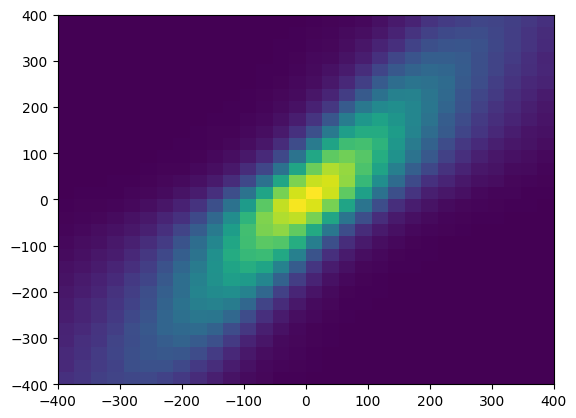

In [6]:
plt.hist2d(tlepCorrect.pz.to_numpy(), 
           tlep_regr.pz.to_numpy(),
           bins=30, range=((-400,400),(-400,400)));

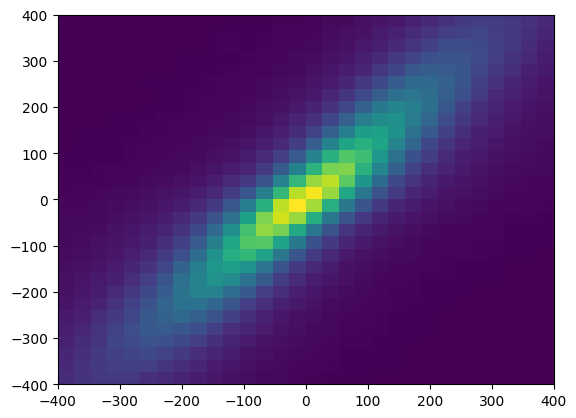

In [7]:
plt.hist2d(thadCorrect.pz.to_numpy(), 
           thad_regr.pz.to_numpy(),
           bins=30, range=((-400,400),(-400,400)));

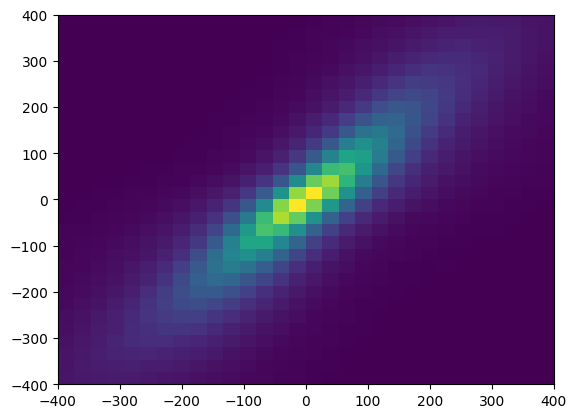

In [8]:
plt.hist2d(higgsCorrect.pz.to_numpy(), 
           higgs_regr.pz.to_numpy(),
           bins=30, range=((-400,400),(-400,400)));


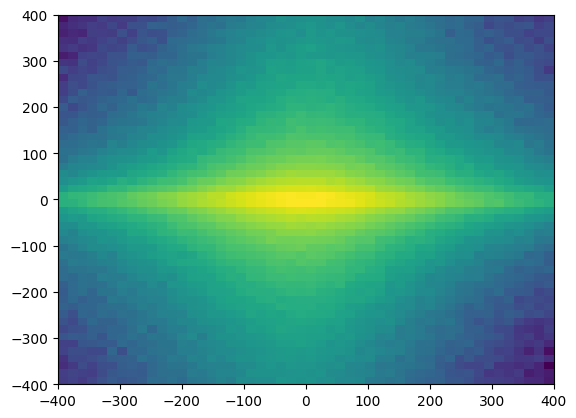

In [74]:
plt.hist2d(higgsCorrect.pz.to_numpy(), 
           glISRCorrect.pz.to_numpy(), 
           bins=50, range=((-400,400),(-400,400)), norm=LogNorm());


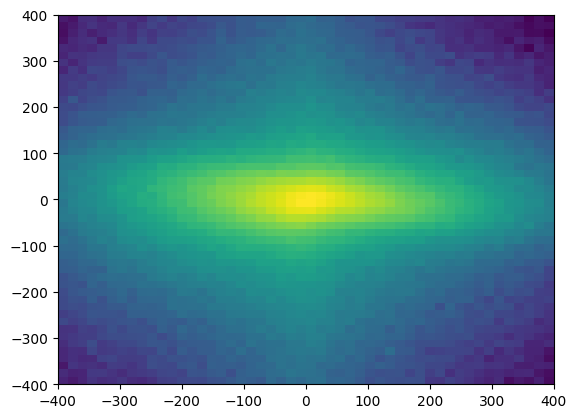

In [75]:
plt.hist2d(higgs_regr.pz.to_numpy(),
           glISR_regr.pz.to_numpy(),
           bins=50, range=((-400,400),(-400,400)), norm=LogNorm());


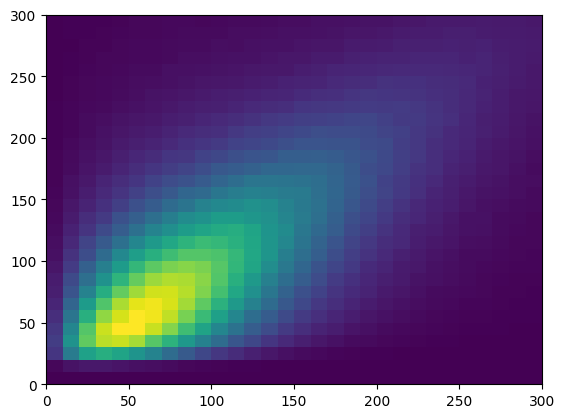

In [11]:
plt.hist2d(higgsCorrect.pt.to_numpy(), 
           higgs_regr.pt.to_numpy(),
           bins=30, range=((0,300),(0,300)));


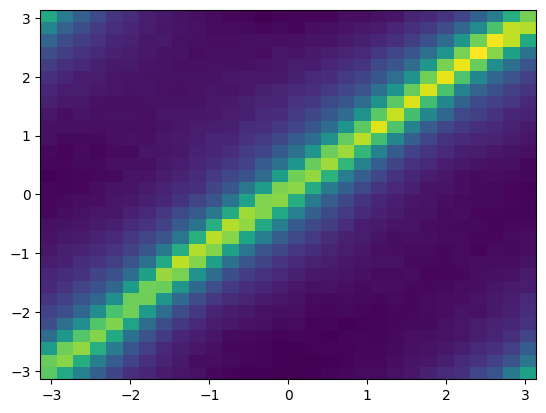

In [12]:
plt.hist2d(glISRCorrect.phi.to_numpy(), 
           glISR_regr.phi.to_numpy(),
           bins=30, range=((-pi,pi),(-pi,pi)));

(array([  2120.,   2160.,   2292.,   2416.,   2494.,   2605.,   2860.,
          2836.,   3025.,   3134.,   3287.,   3532.,   3618.,   3798.,
          4016.,   4216.,   4397.,   4655.,   4923.,   5155.,   5456.,
          5708.,   6152.,   6535.,   7009.,   7260.,   7936.,   8358.,
          8929.,   9825.,  10376.,  11229.,  11818.,  12778.,  13705.,
         14773.,  16017.,  17590.,  18999.,  20604.,  22635.,  25299.,
         28149.,  32280.,  38175.,  46600.,  59278.,  79774., 107424.,
        130483., 128615., 107012.,  82677.,  63424.,  49635.,  39875.,
         32974.,  28312.,  24394.,  21868.,  19440.,  17567.,  15769.,
         14409.,  13264.,  12121.,  11426.,  10251.,   9560.,   9176.,
          8522.,   7831.,   7413.,   6984.,   6524.,   6017.,   5734.,
          5383.,   5271.,   4666.,   4660.,   4517.,   4065.,   3926.,
          3887.,   3594.,   3440.,   3196.,   3103.,   3007.,   2777.,
          2734.,   2598.,   2581.,   2500.,   2331.,   2271.,   2187.,
      

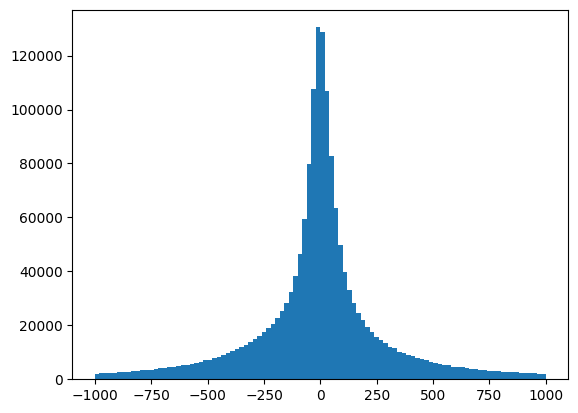

In [78]:
plt.hist(glISR_regr.pz.to_numpy(), range=(-1000,1000),bins=100)

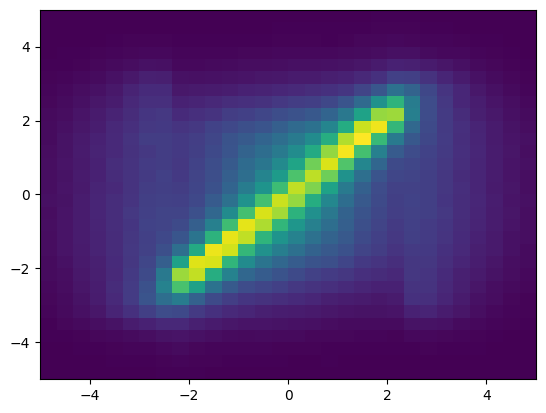

In [13]:
plt.hist2d(glISRCorrect.eta.to_numpy(), 
           glISR_regr.eta.to_numpy(),
           bins=30, range=((-5,5),(-5,5)));

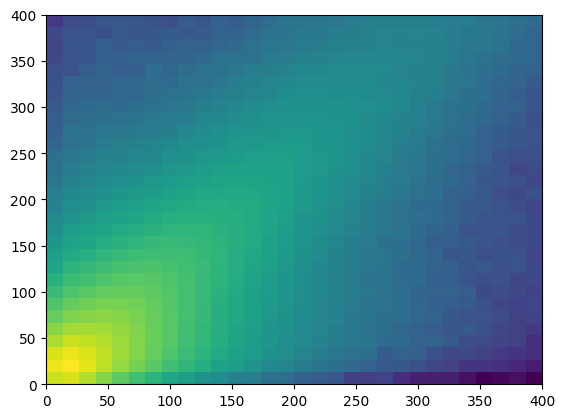

In [14]:
plt.hist2d(glISRCorrect.pt.to_numpy(), 
           glISR_regr.pt.to_numpy(),
           bins=30, range=((0,400),(0,400)), norm=LogNorm());

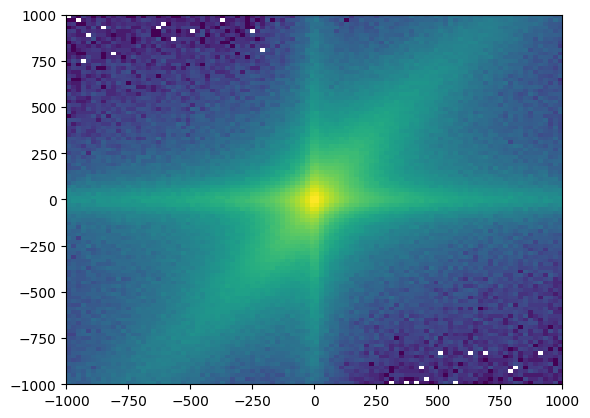

In [82]:
plt.hist2d(glISRCorrect.pz.to_numpy(), 
           glISR_regr.pz.to_numpy(),
           bins=100, range=((-1000,1000),(-1000,1000)), 
          norm=LogNorm());

In [16]:
boost = higgsCorrect + thadCorrect + tlepCorrect + glISRCorrect

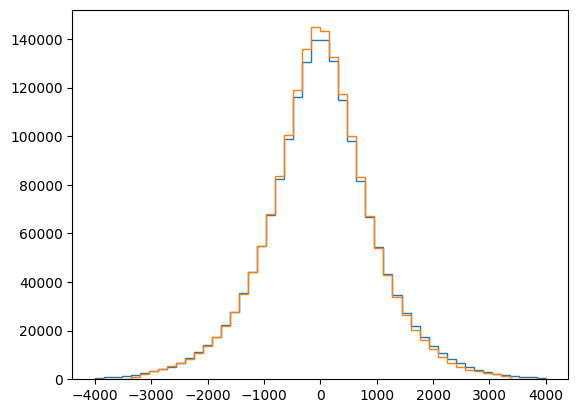

In [17]:
plt.hist(boost.pz.to_numpy(), bins=50, range=(-4000, 4000), histtype="step");
plt.hist(boost_regr.pz.to_numpy(), bins=50, range=(-4000, 4000), histtype="step");

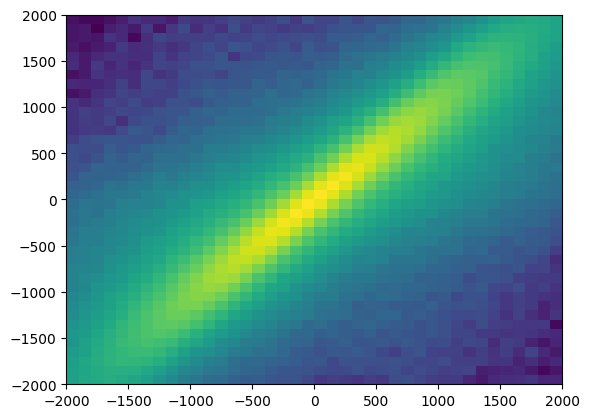

In [83]:
plt.hist2d(boost.pz.to_numpy(), 
           boost_regr.pz.to_numpy(),
           bins=40, range=((-2000,2000),(-2000,2000)), norm=LogNorm());

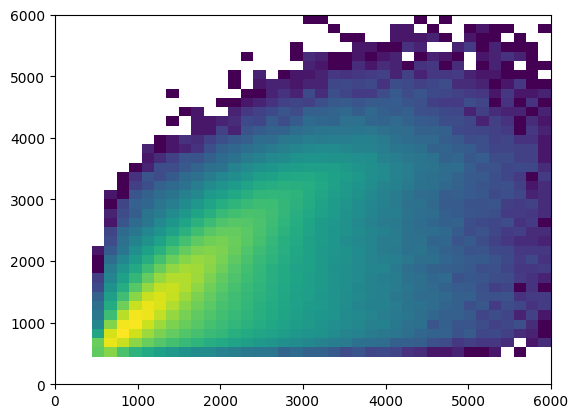

In [19]:
plt.hist2d(boost.E.to_numpy(), 
           boost_regr.E.to_numpy(),
           bins=40, range=((0,6000),(0,6000)), norm=LogNorm());

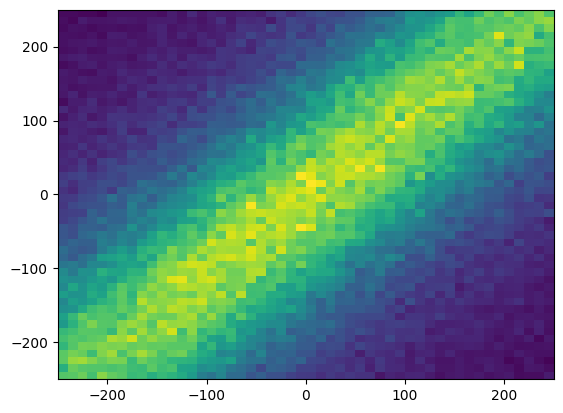

In [20]:
plt.hist2d(boost.pz.to_numpy(), 
           boost_regr.pz.to_numpy(),
           bins=50, range=((-250,250),(-250,250)));

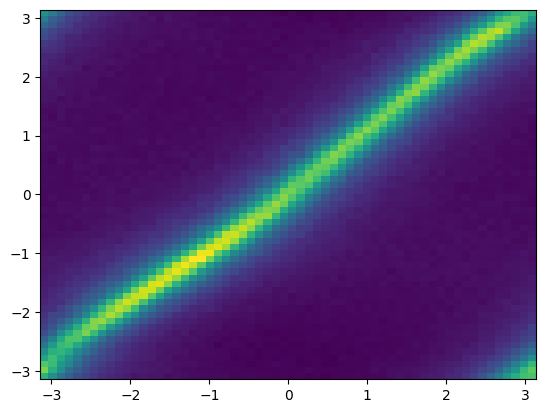

In [21]:
plt.hist2d(higgsCorrect.phi.to_numpy(), 
           higgs_regr.phi.to_numpy(),
           bins=60, range=((-pi,pi),(-pi,pi)),cmin=1);


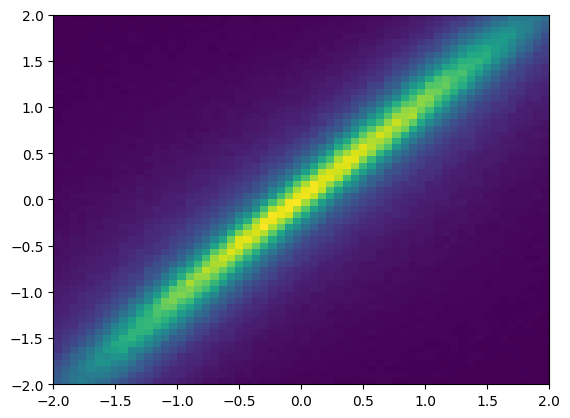

In [22]:
plt.hist2d(thadCorrect.eta.to_numpy(), 
           thad_regr.eta.to_numpy(),
           bins=60, range=((-2,2),(-2,2)),cmin=1);


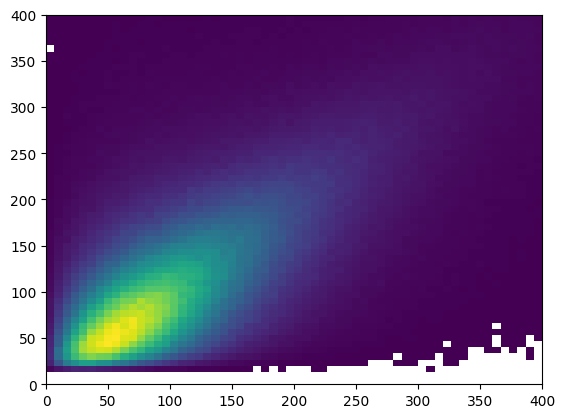

In [23]:
plt.hist2d(higgsCorrect.pt.to_numpy(), 
           higgs_regr.pt.to_numpy(),
           bins=60, range=((0,400),(0,400)),cmin=1);


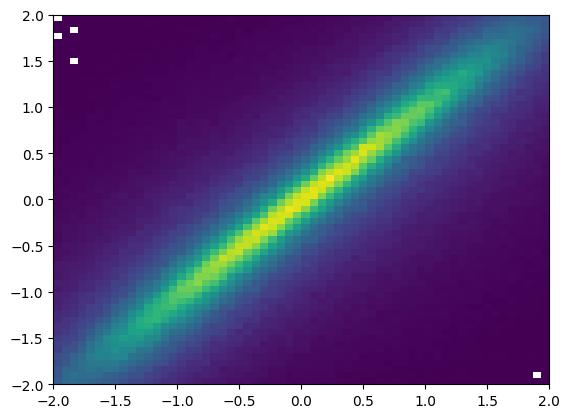

In [24]:
plt.hist2d(higgsCorrect.eta.to_numpy(), 
           higgs_regr.eta.to_numpy(),
           bins=60, range=((-2,2),(-2,2)),cmin=1);


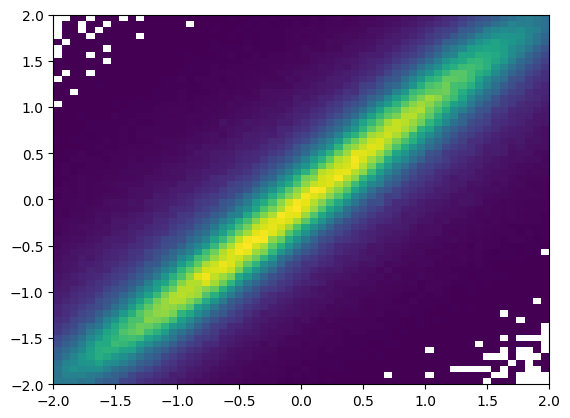

In [25]:
plt.hist2d(tlepCorrect.eta.to_numpy(), 
           tlep_regr.eta.to_numpy(),
           bins=60, range=((-2,2),(-2,2)),cmin=1);


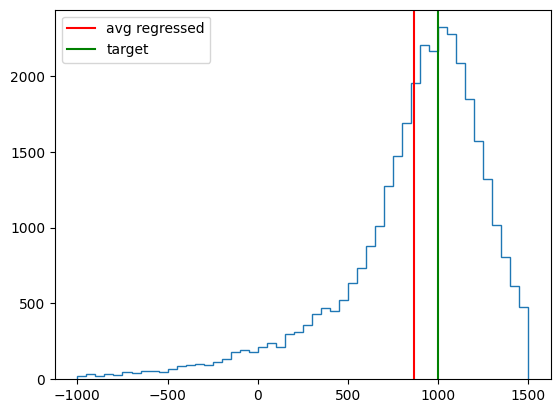

In [67]:
target = 1000
mask = ((boost.pz>(target-50))&(boost.pz<(target+50))).to_numpy()
plt.hist(boost_regr[mask].pz.to_numpy(), bins=50, range=(-1000,1500), histtype="step");
plt.axvline(np.mean(boost_regr[mask].pz.to_numpy()), c='r', label="avg regressed")
plt.axvline(target, c='g', label="target")
plt.legend()
#plt.axvline( torch.quantile(data_regressed[mask, 0, 1]), c='r')

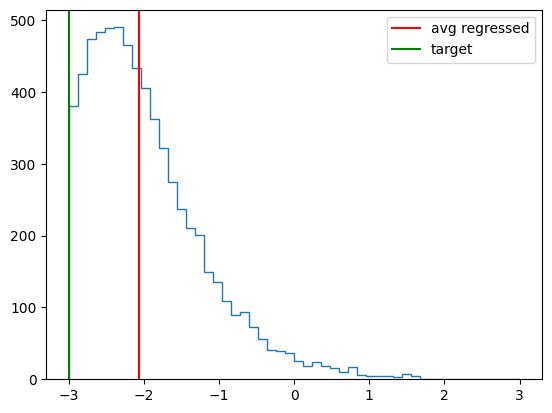

In [69]:
target = -3
mask = ((higgsCorrect.eta>(target-0.1))&(higgsCorrect.eta<(target+0.1))).to_numpy()
plt.hist(higgs_regr[mask].eta.to_numpy(), bins=50, range=(-3,3), histtype="step");
plt.axvline(np.mean(higgs_regr[mask].eta.to_numpy()), c='r', label="avg regressed")
plt.axvline(target, c='g', label="target")
plt.legend()
#plt.axvline( torch.quantile(data_regressed[mask, 0, 1]), c='r')

Text(0.5, 1.0, 'Gluon')

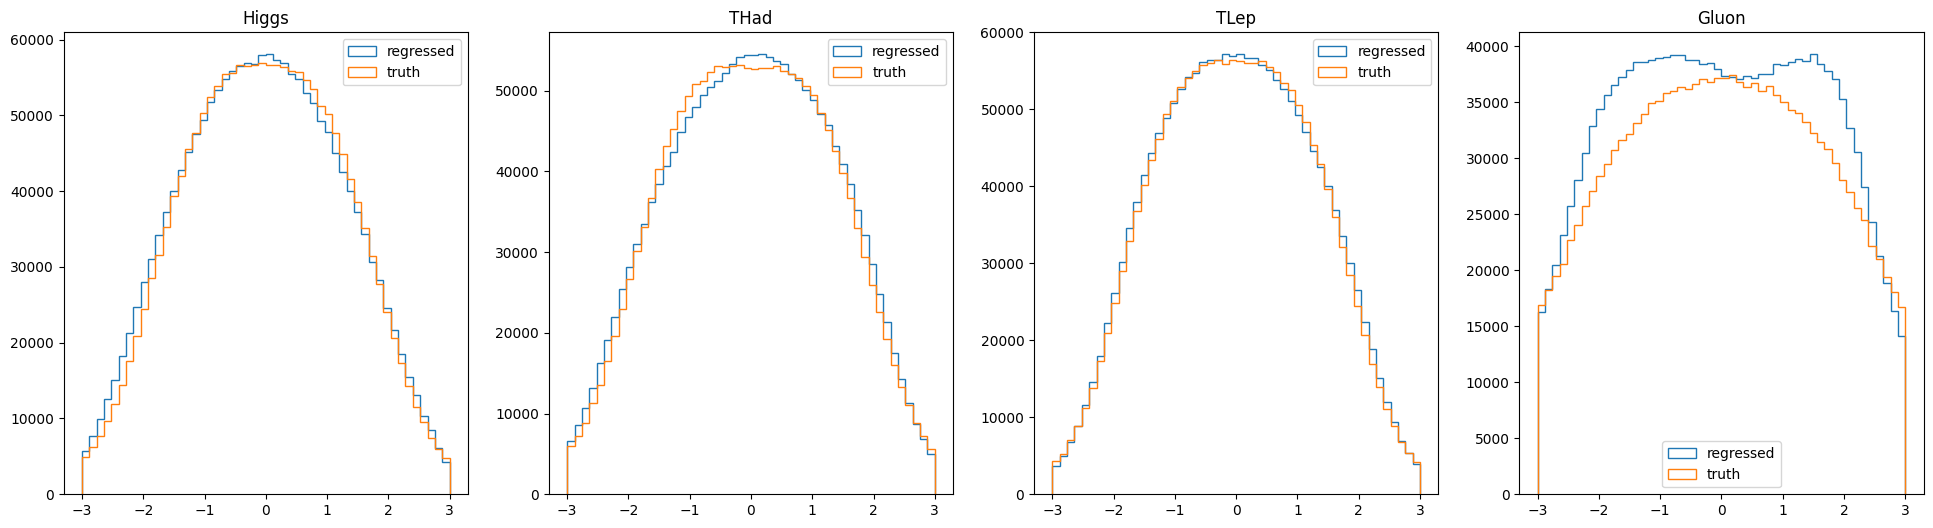

In [28]:
f, axs = plt.subplots(1,4 , figsize =(24,6))
axs[0].hist(higgs_regr.eta.to_numpy(), bins=50, range=(-3,3), histtype="step", label="regressed");
axs[0].hist(higgsCorrect.eta, bins=50, range=(-3, 3), histtype="step",  label="truth");
axs[0].legend()
axs[0].set_title("Higgs")

axs[1].hist(thad_regr.eta.to_numpy(), bins=50, range=(-3,3), histtype="step", label="regressed");
axs[1].hist(thadCorrect.eta, bins=50, range=(-3, 3), histtype="step",  label="truth");
axs[1].legend()
axs[1].set_title("THad")

axs[2].hist(tlep_regr.eta.to_numpy(), bins=50, range=(-3,3), histtype="step", label="regressed");
axs[2].hist(tlepCorrect.eta, bins=50, range=(-3, 3), histtype="step",  label="truth");
axs[2].legend()
axs[2].set_title("TLep")

axs[3].hist(glISR_regr.eta.to_numpy(), bins=50, range=(-3,3), histtype="step", label="regressed");
axs[3].hist(glISRCorrect.eta, bins=50, range=(-3, 3), histtype="step",  label="truth");
axs[3].legend()
axs[3].set_title("Gluon")

Text(0.5, 1.0, 'Gluon')

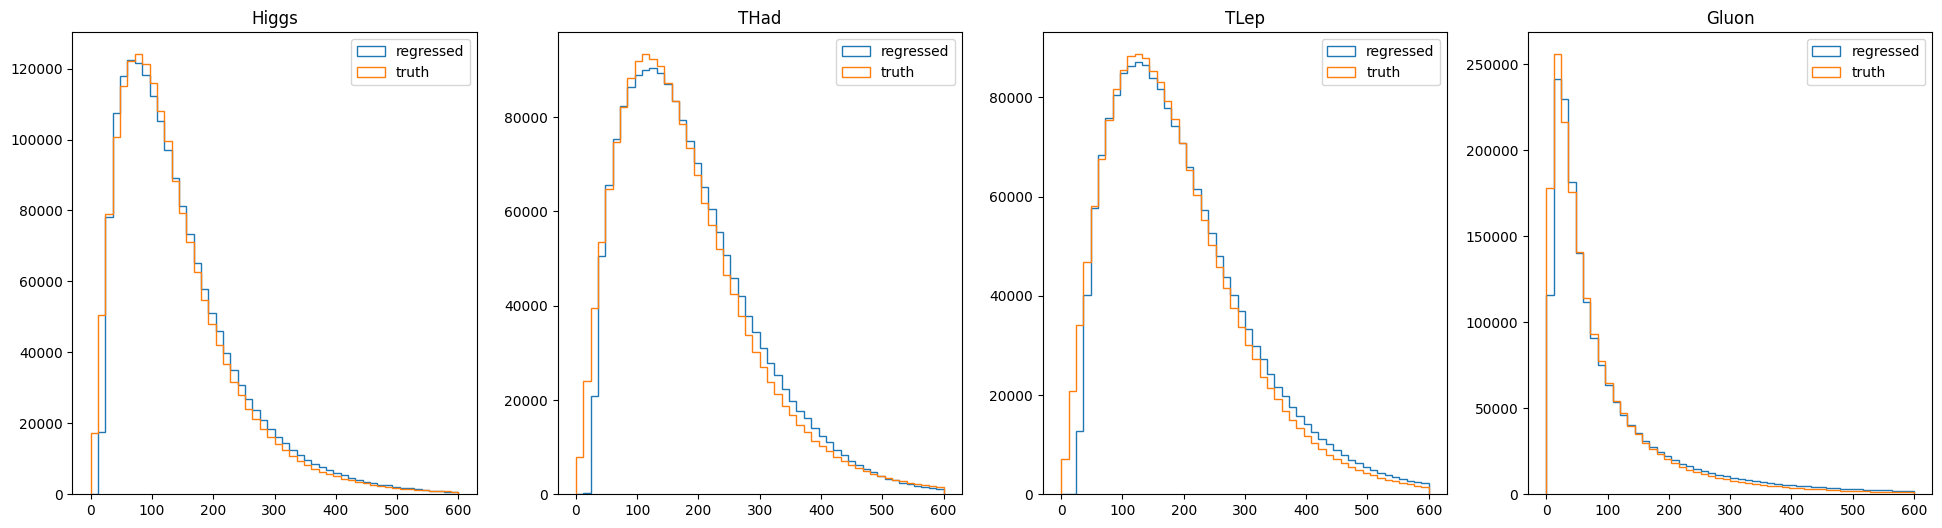

In [29]:
f, axs = plt.subplots(1,4 , figsize =(24,6))
axs[0].hist(higgs_regr.pt.to_numpy(), bins=50, range=(0, 600), histtype="step", label="regressed");
axs[0].hist(higgsCorrect.pt, bins=50, range=(0, 600), histtype="step",  label="truth");
axs[0].legend()
axs[0].set_title("Higgs")

axs[1].hist(thad_regr.pt.to_numpy(), bins=50, range=(0, 600), histtype="step", label="regressed");
axs[1].hist(thadCorrect.pt, bins=50, range=(0, 600), histtype="step",  label="truth");
axs[1].legend()
axs[1].set_title("THad")

axs[2].hist(tlep_regr.pt.to_numpy(), bins=50, range=(0, 600), histtype="step", label="regressed");
axs[2].hist(tlepCorrect.pt, bins=50, range=(0, 600), histtype="step",  label="truth");
axs[2].legend()
axs[2].set_title("TLep")

axs[3].hist(glISR_regr.pt.to_numpy(), bins=50, range=(0, 600), histtype="step", label="regressed");
axs[3].hist(glISRCorrect.pt, bins=50, range=(0, 600), histtype="step",  label="truth");
axs[3].legend()
axs[3].set_title("Gluon")

In [45]:
data_regressed[:,:,2][ data_regressed[:,:,2]>pi] = data_regressed[:,:,2][ data_regressed[:,:,2]>pi] - 2*pi
data_regressed[:,:,2][ data_regressed[:,:,2]<-pi] = data_regressed[:,:,2][ data_regressed[:,:,2]<-pi] + 2*pi

Text(0.5, 1.0, 'Gluon')

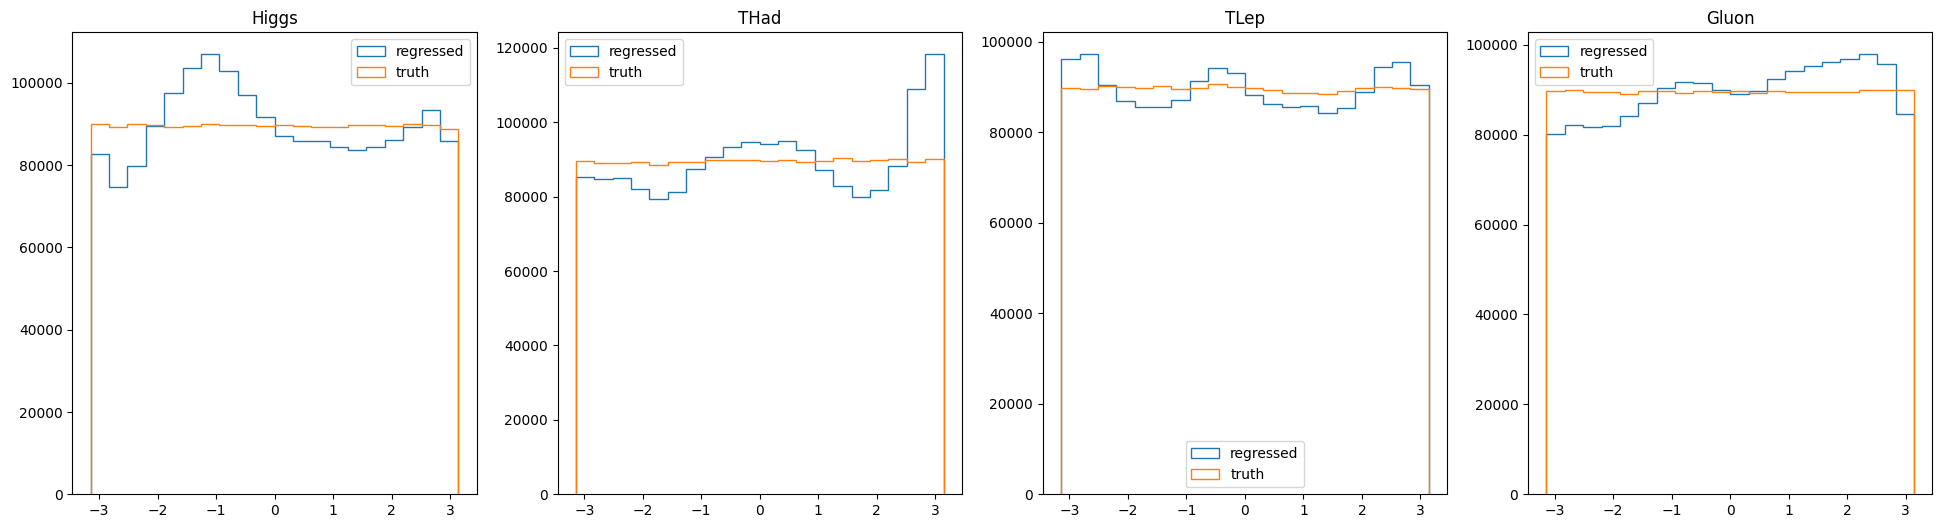

In [31]:
f, axs = plt.subplots(1,4 , figsize =(24,6))
axs[0].hist(higgs_regr.phi, bins=20, range=(-pi,pi), histtype="step", label="regressed");
axs[0].hist(higgsCorrect.phi, bins=20, range=(-pi,pi), histtype="step",  label="truth");
axs[0].legend()
axs[0].set_title("Higgs")

axs[1].hist(thad_regr.phi,bins=20, range=(-pi,pi), histtype="step", label="regressed");
axs[1].hist(thadCorrect.phi, bins=20, range=(-pi,pi), histtype="step",  label="truth");
axs[1].legend()
axs[1].set_title("THad")

axs[2].hist(tlep_regr.phi, bins=20, range=(-pi,pi), histtype="step", label="regressed");
axs[2].hist(tlepCorrect.phi, bins=20, range=(-pi,pi), histtype="step",  label="truth");
axs[2].legend()
axs[2].set_title("TLep")


axs[3].hist(glISR_regr.phi, bins=20, range=(-pi,pi), histtype="step", label="regressed");
axs[3].hist(glISRCorrect.phi, bins=20, range=(-pi,pi), histtype="step",  label="truth");
axs[3].legend()
axs[3].set_title("Gluon")

# Study the correlations

In [56]:
stacked_tensors = torch.stack( (
                        torch.from_numpy(higgs_regr.pt.to_numpy()),
                        torch.from_numpy(higgs_regr.eta.to_numpy())
    
                            ), dim=0)

In [57]:
stacked_tensors

tensor([[ 73.2992, 179.6664,  93.2382,  ...,  53.9025,  98.6083, 127.2525],
        [ -1.6691,   1.1546,   2.2897,  ...,   0.3532,   2.5615,   1.5216]])

In [58]:
mean = torch.mean(stacked_tensors, dim=0)
std_dev = torch.std(stacked_tensors, dim=0)
normalized_tensors = (stacked_tensors - mean) / std_dev
correlation_matrix = torch.mm(normalized_tensors, normalized_tensors.t()) / (normalized_tensors.size(0) - 1)

In [63]:
normalized_tensors

tensor([[ 0.7071,  0.7071,  0.7071,  ...,  0.7071,  0.7071,  0.7071],
        [-0.7071, -0.7071, -0.7071,  ..., -0.7071, -0.7071, -0.7071]])

In [62]:
correlation_matrix

tensor([[ 896062.5000, -896062.5000],
        [-896062.5000,  896062.5000]])

# Check residuals

Text(0, 0.5, 'Tlep pt')

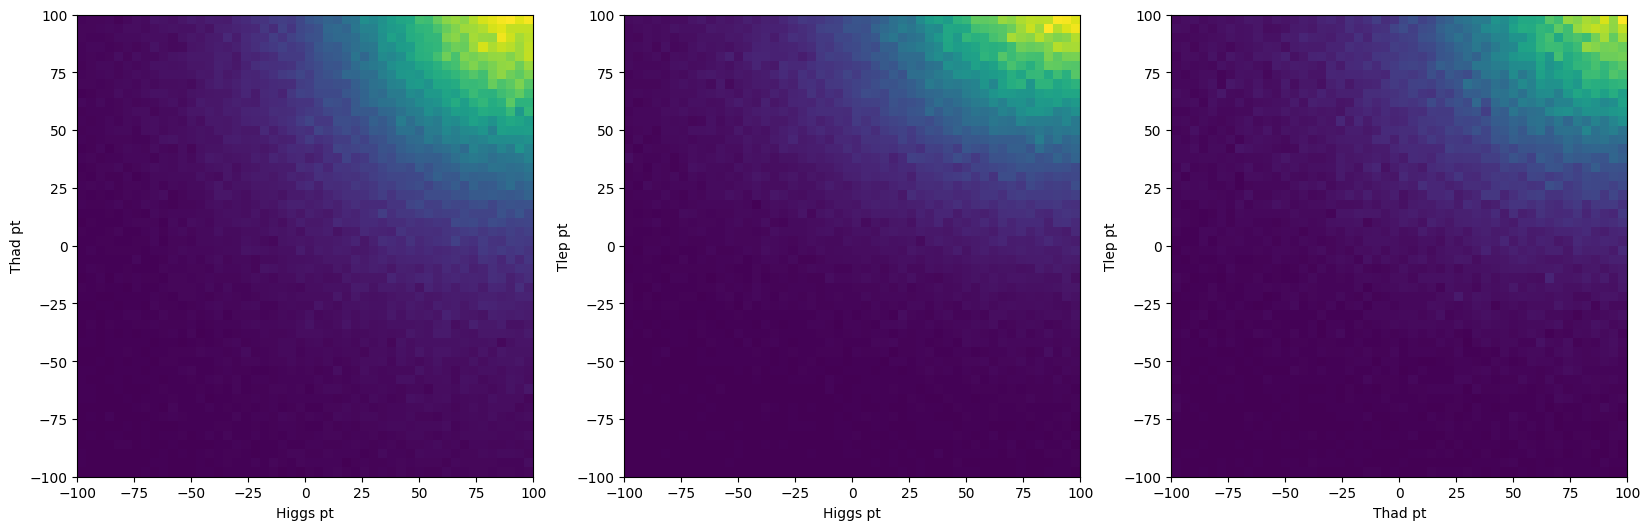

In [52]:
f, axs = plt.subplots(1,3 , figsize =(20,6))

axs[0].hist2d(
    data_regressed[:, 0, 0].cpu().numpy()- higgsCorrect.pt.to_numpy(),
    data_regressed[:, 1, 0].cpu().numpy()- thadCorrect.pt.to_numpy(),
    bins=50, 
    range=((-100,100), (-100,100))
);
axs[0].set_xlabel("Higgs pt")
axs[0].set_ylabel("Thad pt")

axs[1].hist2d(
    data_regressed[:, 0, 0].cpu().numpy()- higgsCorrect.pt.to_numpy(),
    data_regressed[:, 2, 0].cpu().numpy()- tlepCorrect.pt.to_numpy(),
    bins=50, 
    range=((-100,100), (-100,100))
)
axs[1].set_xlabel("Higgs pt")
axs[1].set_ylabel("Tlep pt")

axs[2].hist2d(
    data_regressed[:, 1, 0].cpu().numpy()- thadCorrect.pt.to_numpy(),
    data_regressed[:, 2, 0].cpu().numpy()- tlepCorrect.pt.to_numpy(),
    bins=50, 
    range=((-100,100), (-100,100))
)
axs[2].set_xlabel("Thad pt")
axs[2].set_ylabel("Tlep pt")

Text(0, 0.5, 'Tlep eta')

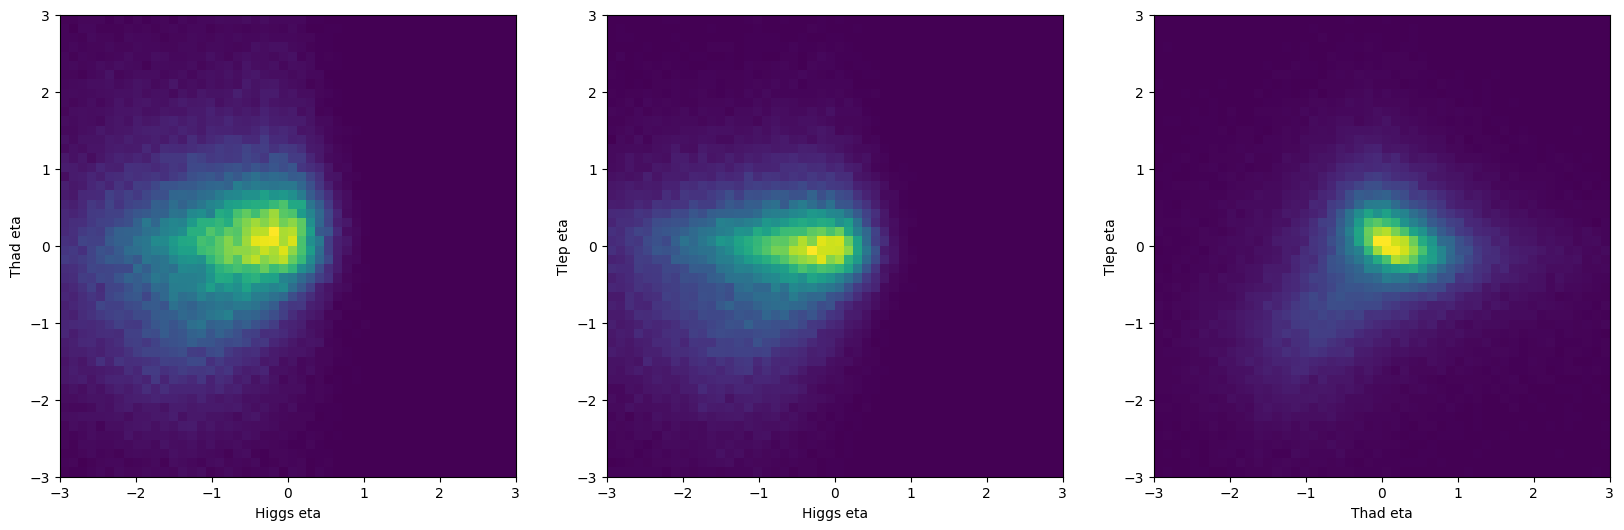

In [73]:
f, axs = plt.subplots(1,3 , figsize =(20,6))

mask = (higgsCorrect.eta>1.5).to_numpy()
axs[0].hist2d(
    data_regressed[mask, 0, 1].cpu().numpy()- higgsCorrect[mask].eta.to_numpy(),
    data_regressed[mask, 1, 1].cpu().numpy()- thadCorrect[mask].eta.to_numpy(),
    bins=50, 
    range=((-3,3), (-3,3))
);
axs[0].set_xlabel("Higgs eta")
axs[0].set_ylabel("Thad eta")

axs[1].hist2d(
    data_regressed[mask, 0, 1].cpu().numpy()- higgsCorrect[mask].eta.to_numpy(),
    data_regressed[mask, 2, 1].cpu().numpy()- tlepCorrect[mask].eta.to_numpy(),
    bins=50, 
    range=((-3,3), (-3,3))
)
axs[1].set_xlabel("Higgs eta")
axs[1].set_ylabel("Tlep eta")

axs[2].hist2d(
    data_regressed[mask, 1, 1].cpu().numpy()- thadCorrect[mask].eta.to_numpy(),
    data_regressed[mask, 2, 1].cpu().numpy()- tlepCorrect[mask].eta.to_numpy(),
    bins=50, 
    range=((-3,3), (-3,3))
)
axs[2].set_xlabel("Thad eta")
axs[2].set_ylabel("Tlep eta")

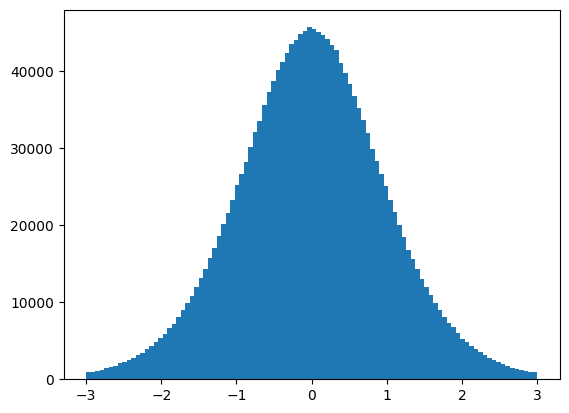

In [160]:
plt.hist(higgsCorrect.eta, bins=100, range=(-3,3));

In [53]:
target = 1.5
mask = ((higgsCorrect[:batch_size*N].eta>(target-0.1))&(higgsCorrect[:batch_size*N].eta<(target+0.1))).to_numpy()
plt.hist(higgs_regr[mask].eta.to_numpy(), bins=50, histtype="step");
plt.axvline(np.mean(higgs_regr[mask].eta.to_numpy()), c='r', label="avg regressed")
plt.axvline(target, c='g', label="target")
plt.legend()
#plt.axvline( torch.quantile(data_regressed[mask, 0, 1]), c='r')

NameError: name 'batch_size' is not defined

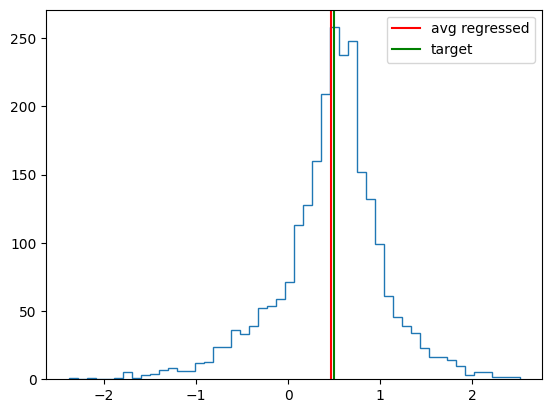

In [81]:
target = 0.5
mask = ((thadCorrect[:batch_size*N].eta>(target-0.1))&(thadCorrect[:batch_size*N].eta<(target+0.1))).to_numpy()
plt.hist(thad_regr[mask].eta.to_numpy(), bins=50, histtype="step");
plt.axvline(np.mean(thad_regr[mask].eta.to_numpy()), c='r', label="avg regressed")
plt.axvline(target, c='g', label="target")
plt.legend()
#plt.axvline( torch.quantile(data_regressed[mask, 0, 1]), c='r')

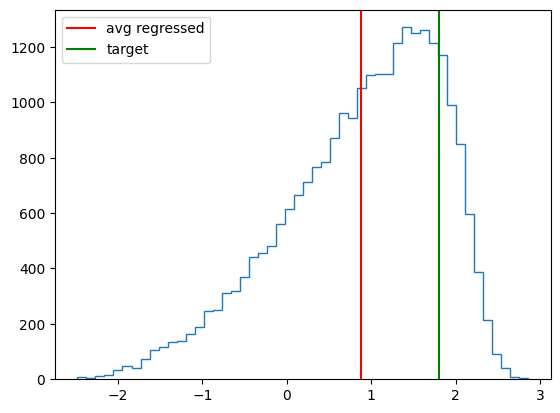

In [75]:
target = 1.8
mask = ((higgsCorrect.eta>(target-0.1))&(higgsCorrect.eta<(target+0.1))).to_numpy()
plt.hist(data_regressed[mask, 0, 1], bins=50, histtype="step");
plt.axvline(torch.mean(data_regressed[mask, 0, 1]), c='r', label="avg regressed")
plt.axvline(target, c='g', label="target")
plt.legend()
#plt.axvline( torch.quantile(data_regressed[mask, 0, 1]), c='r')

(array([2.00000e+00, 0.00000e+00, 2.00000e+00, 4.00000e+00, 1.00000e+01,
        2.00000e+01, 3.50000e+01, 5.30000e+01, 1.25000e+02, 2.13000e+02,
        4.59000e+02, 8.64000e+02, 1.53100e+03, 2.89700e+03, 5.63500e+03,
        1.00430e+04, 1.83490e+04, 3.30140e+04, 5.60280e+04, 8.85770e+04,
        1.32360e+05, 1.76311e+05, 2.08777e+05, 2.24579e+05, 2.18886e+05,
        1.92739e+05, 1.51139e+05, 1.06911e+05, 6.91620e+04, 4.13600e+04,
        2.36390e+04, 1.32380e+04, 7.12200e+03, 3.83100e+03, 1.95300e+03,
        1.05700e+03, 5.79000e+02, 2.88000e+02, 1.62000e+02, 7.20000e+01,
        4.20000e+01, 2.50000e+01, 1.90000e+01, 4.00000e+00, 4.00000e+00,
        1.00000e+00, 2.00000e+00, 1.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([-7.64110512, -7.31893532, -6.99676551, -6.67459571, -6.3524259 ,
        -6.0302561 , -5.70808629, -5.38591648, -5.06374668, -4.74157687,
        -4.41940707, -4.09723726, -3.77506746, -3.45289765, -3.13072784,
        -2.80855804, -2.48638823, -2.16421843, -1

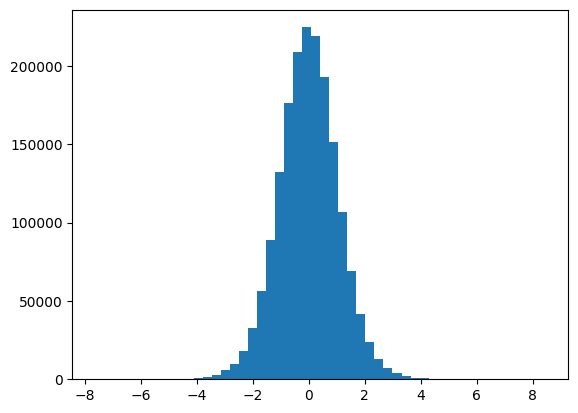

In [70]:
plt.hist(thadCorrect.eta, bins=50)

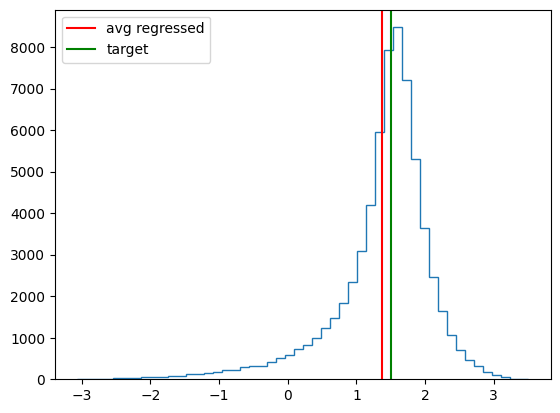

In [32]:
target = 1.5
mask = ((thadCorrect.eta>(target-0.1))&(thadCorrect.eta<(target+0.1))).to_numpy()
plt.hist(thad_regr[mask].eta, bins=50, histtype="step");
plt.axvline(ak.mean(thad_regr[mask].eta), c='r', label="avg regressed")
plt.axvline(target, c='g', label="target")
plt.legend()
#plt.axvline( torch.quantile(data_regressed[mask, 0, 1]), c='r')

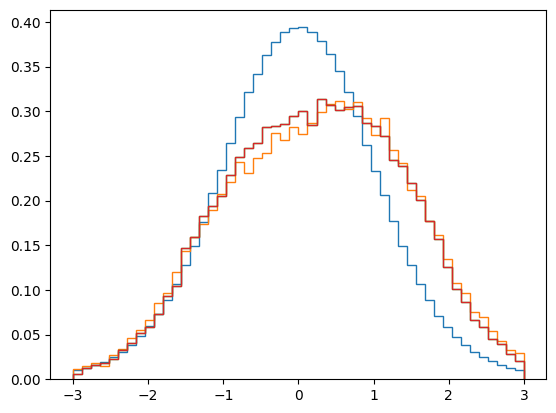

In [86]:
plt.hist(thadCorrect.eta, histtype="step", bins=50, range=(-3,3), density=True);
plt.hist(thadCorrect[higgsCorrect.eta>2].eta, histtype="step", bins=50, range=(-3,3),density=True);
plt.hist(tlepCorrect[higgsCorrect.eta>2].eta, histtype="step", bins=50, range=(-3,3),density=True);
plt.hist(tlepCorrect[higgsCorrect.eta>2].eta, histtype="step", bins=50, range=(-3,3),density=True);

In [33]:
boost_reco = data_val.reco_data.data_boost.squeeze(1)
boost_truth = data_val.parton_data.data_boost.squeeze(1)

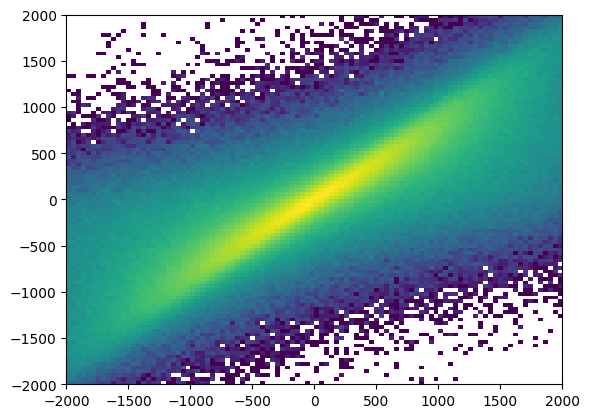

In [65]:
plt.hist2d( boost_truth[:, 3].numpy(), 
            boost_reco[:,3].numpy(), 
          bins=100, range=((-2000, 2000),(-2000, 2000)), norm=LogNorm());

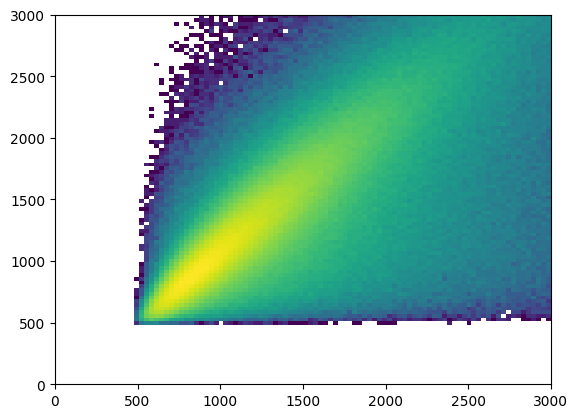

In [41]:
plt.hist2d( boost.E.to_numpy(), 
            boost_regr.E.to_numpy(), 
          bins=100, range=((0, 3000),(0, 3000)), norm=LogNorm());

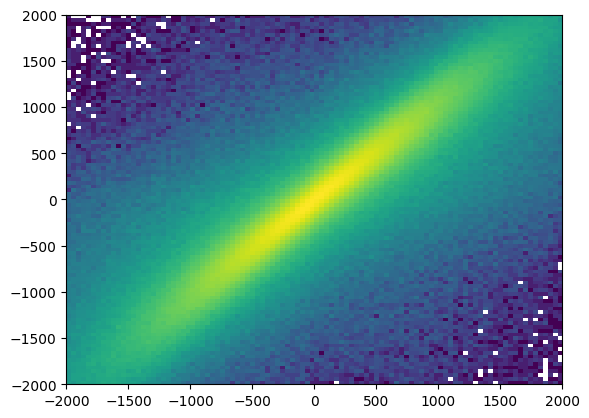

In [66]:
plt.hist2d( boost_truth[:, 3].numpy(), 
            boost_regr.pz.to_numpy(), 
          bins=100, range=((-2000, 2000),(-2000, 2000)), norm=LogNorm());

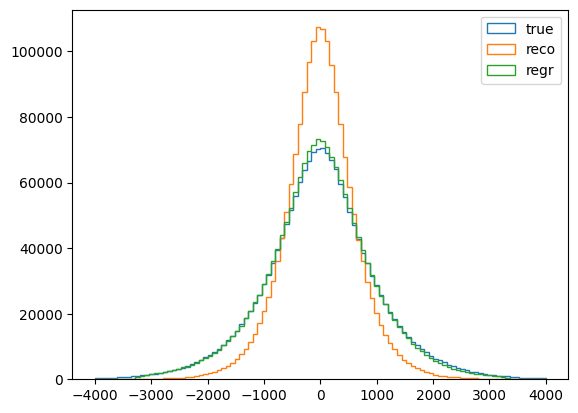

In [36]:
plt.hist(boost_truth[:,3].numpy(), bins=100, histtype="step", range=(-4000,4000), label="true");
plt.hist(boost_reco[:,3].numpy(), bins=100, histtype="step", range=(-4000,4000), label="reco");
plt.hist(boost_regr.pz.to_numpy(), bins=100, histtype="step", range=(-4000,4000), label="regr");
plt.legend()

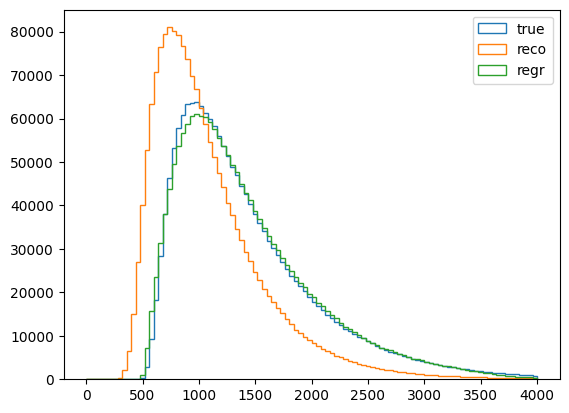

In [43]:
plt.hist(boost_truth[:,0].numpy(), bins=100, histtype="step", range=(0,4000), label="true");
plt.hist(boost_reco[:,0].numpy(), bins=100, histtype="step", range=(0,4000), label="reco");
plt.hist(boost_regr.E.to_numpy(), bins=100, histtype="step", range=(0,4000), label="regr");
plt.legend()

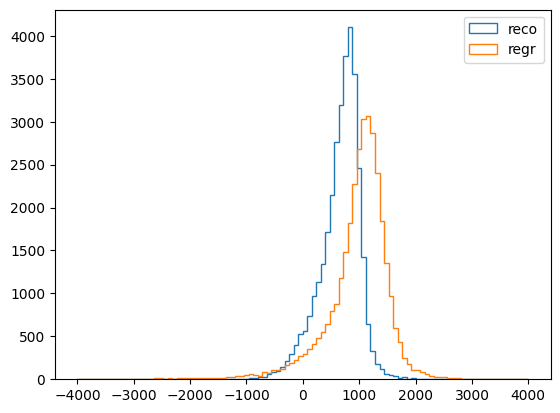

In [66]:
plt.hist(boost_reco[(boost_truth[:,3]>1000)&(boost_truth[:,3]<1100),3].numpy(), bins=100, histtype="step", range=(-4000,4000), label="reco");
plt.hist(boost_regr.pz.to_numpy()[(boost_truth[:,3]>1000)&(boost_truth[:,3]<1100)], bins=100, histtype="step", range=(-4000,4000), label="regr");
plt.legend()

In [62]:
M_HIGGS = 125.25
M_TOP = 172.76

higgs = data_regressed[:,0]
thad = data_regressed[:,1]
tlep = data_regressed[:,2]

higgs = vector.array(
    {
        "pt": higgs[:,0].detach().numpy(),
        "eta": higgs[:,1].detach().numpy(),
        "phi": higgs[:,2].detach().numpy(),
        "mass": M_HIGGS*np.ones(higgs.shape[0])
    }
)

thad = vector.array(
    {
        "pt": thad[:,0].detach().numpy(),
        "eta": thad[:,1].detach().numpy(),
        "phi": thad[:,2].detach().numpy(),
        "mass": M_TOP*np.ones(thad.shape[0])
    }
)

tlep = vector.array(
    {
        "pt": tlep[:,0].detach().numpy(),
        "eta": tlep[:,1].detach().numpy(),
        "phi": tlep[:,2].detach().numpy(),
        "mass": M_TOP*np.ones(tlep.shape[0])
    }
)

higgs = ak.with_name(higgs, name="Momentum4D")
thad = ak.with_name(thad, name="Momentum4D")
tlep = ak.with_name(tlep, name="Momentum4D")

In [63]:
gluon_px = -(higgs.px + thad.px + tlep.px)
gluon_py = -(higgs.py + thad.py + tlep.py)
gluon_pz = -(higgs.pz + thad.pz + tlep.pz)
E_gluon = np.sqrt(gluon_px**2 + gluon_py**2 + gluon_pz**2)

gluon_px = np.expand_dims(gluon_px, axis=1)
gluon_py = np.expand_dims(gluon_py, axis=1)
gluon_pz = np.expand_dims(gluon_pz, axis=1)
E_gluon = np.expand_dims(E_gluon, axis=1)

gluon = np.concatenate((E_gluon, gluon_px, gluon_py, gluon_pz), axis=1)

glISR = vector.array(
    {
        "E": gluon[:,0],
        "px": gluon[:,1],
        "py": gluon[:,2],
        "pz": gluon[:,3],
    }
)


glISR = ak.with_name(glISR, name="Momentum4D")

boost_regressed = higgs + thad + tlep + glISR
boost_regressed = to_flat_tensor(boost_regressed, ["t", "x", "y", "z"], axis=1, allow_missing=False)

In [28]:
higgs_tensor = to_flat_tensor(higgs, ["t", "x", "y", "z"], axis=1, allow_missing=False).unsqueeze(dim=1)
thad_tensor = to_flat_tensor(thad, ["t", "x", "y", "z"], axis=1, allow_missing=False).unsqueeze(dim=1)
tlep_tensor = to_flat_tensor(tlep, ["t", "x", "y", "z"], axis=1, allow_missing=False).unsqueeze(dim=1)
gluon_tensor = torch.Tensor(gluon).unsqueeze(dim=1)

new_data_regressed = torch.cat((higgs_tensor, thad_tensor, tlep_tensor, gluon_tensor), dim=1)
print(new_data_regressed.shape)

KeyboardInterrupt: 

# Split in matched/unmatched

In [17]:
df = ak.from_parquet(path_data)
jets = df.jets
jets = ak.with_name(jets, name="Momentum4D")

x = FindMasks()
higgs_mask = x.higgs_mask(jets)
thad_mask = x.thad_mask(jets)
tlep_mask = x.tlep_mask(jets)
ISR_mask = x.ISR_mask(jets)

In [18]:
higgs_mask.sum()

1080513

In [19]:
higgs_mask.shape

(1792125,)

In [61]:
njets5

tensor([ True,  True, False,  ...,  True,  True,  True])

In [63]:
njets5 = (data.reco_data.mask_jets.sum(1) > 4).numpy()

(array([9.00153e+05, 4.92009e+05, 2.54955e+05, 9.97400e+04, 3.27050e+04,
        9.37700e+03, 2.47000e+03, 5.91000e+02, 1.01000e+02, 2.40000e+01]),
 array([ 4. ,  5.1,  6.2,  7.3,  8.4,  9.5, 10.6, 11.7, 12.8, 13.9, 15. ]),
 <BarContainer object of 10 artists>)

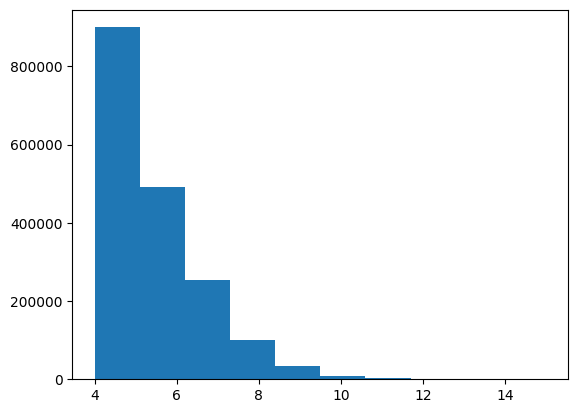

In [58]:
plt.hist(data.reco_data.mask_jets.sum(1).numpy())

# HIGGS NEW BINNING

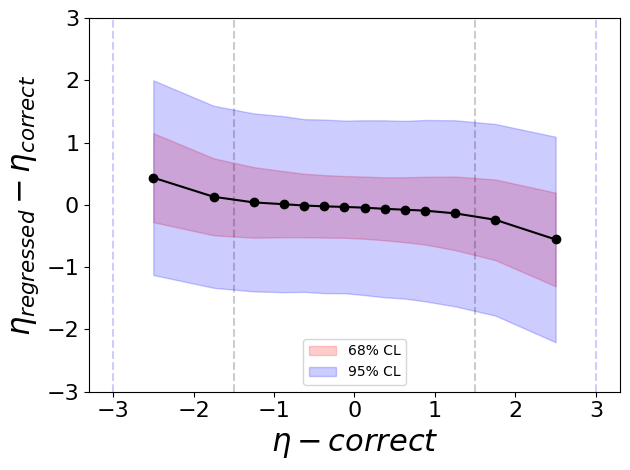

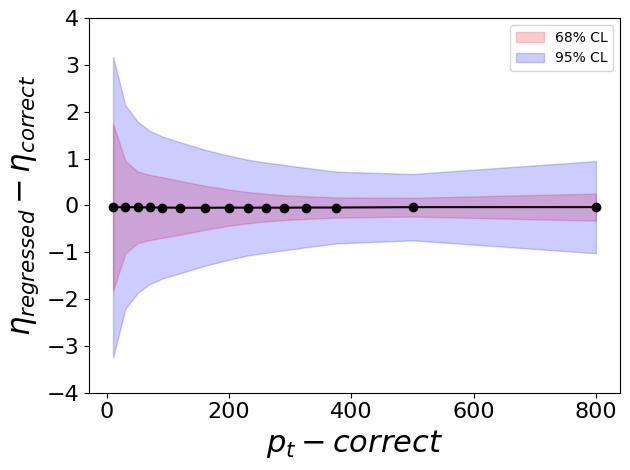

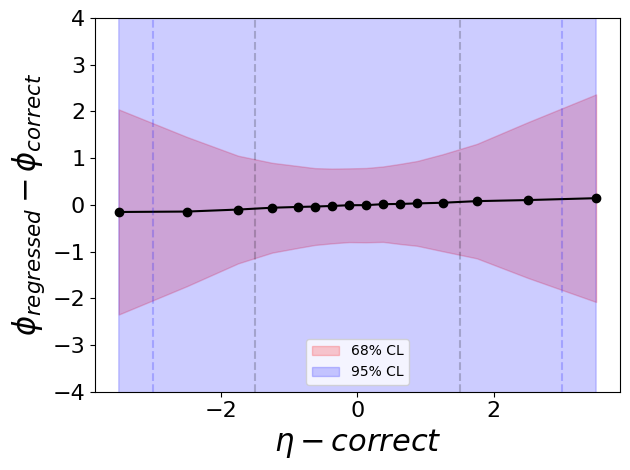

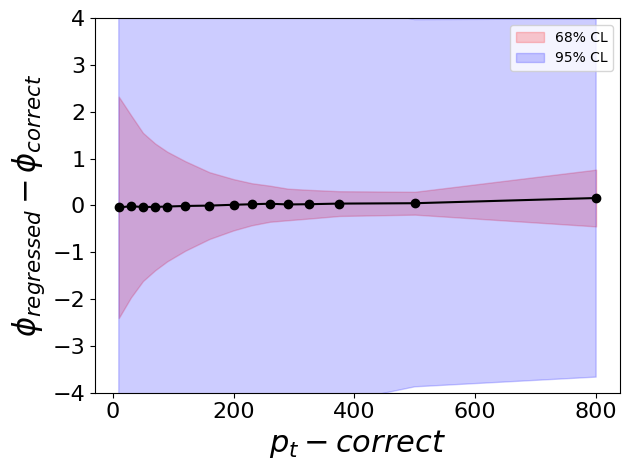

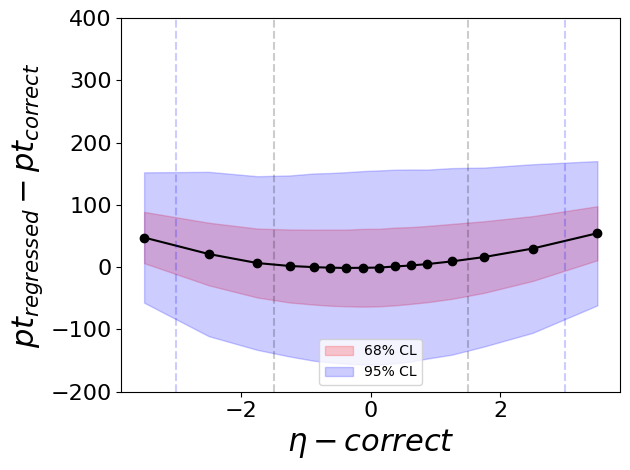

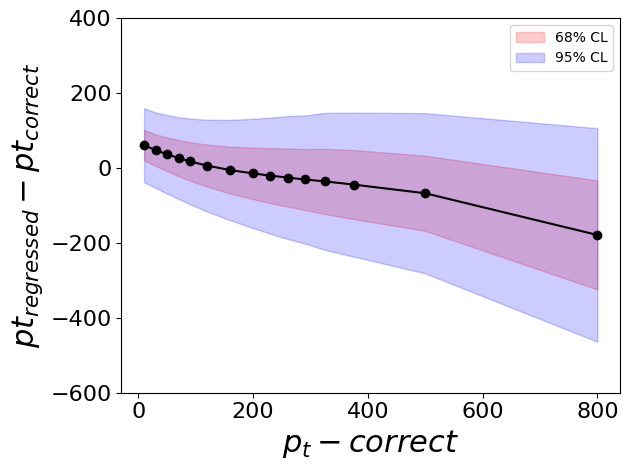

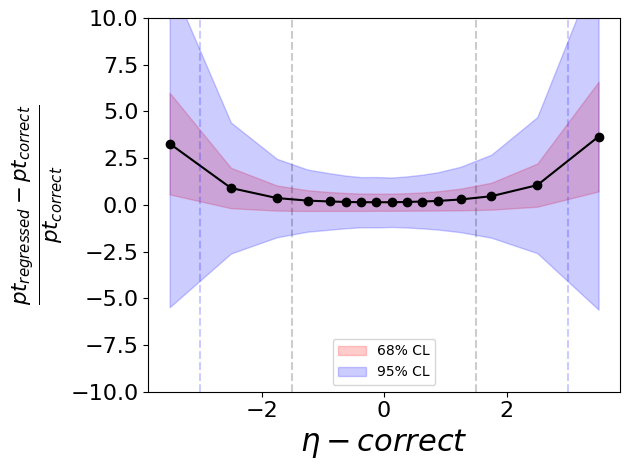

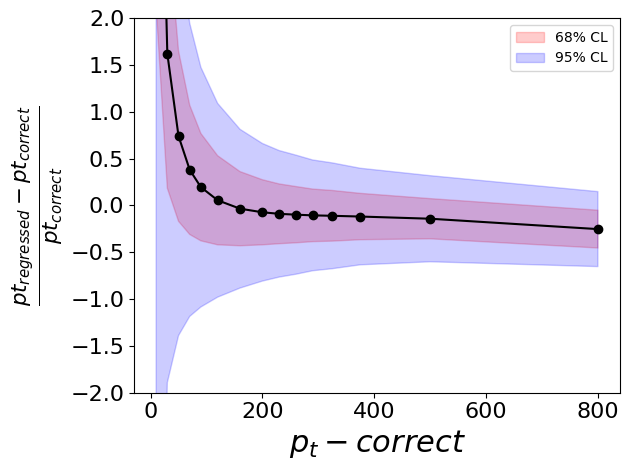

In [44]:
nameDir = 'plots/flow_pretraining_spanet/preTraining_spanet_v2_noProv'
os.makedirs(nameDir, exist_ok=True)

plot_regressionFactor(higgs_regr.eta, higgsCorrect.eta, higgsCorrect.eta, matched=None,
                      intervalTargetVar=[-3,-2,-1.5,-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.5,2,3],
                      limTarget=(-3, 3), bins=8, ylim=[-3,3], xname='$\eta-correct$',
                      yname='$\eta_{regressed} - \eta_{correct}$', eta=True,
                     nameDir=nameDir, nameFig='1.png')

plot_regressionFactor(higgs_regr.eta, higgsCorrect.eta, higgsCorrect.pt, matched=None,
                      intervalTargetVar=[0,20,40,60,80,100,140,180,220,240,280,300,350,400,600,1000],
                      limTarget=(0, 1000), bins=20, ylim=[-4,4], xname='$p_t-correct$',
                      yname='$\eta_{regressed} - \eta_{correct}$',
                     nameDir=nameDir, nameFig='2.png')

plot_regressionFactor(higgs_regr.phi, higgsCorrect.phi, higgsCorrect.eta, matched=None,
                      intervalTargetVar=[-4,-3,-2,-1.5,-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.5,2,3,4],
                      limTarget=(-4, 4), bins=8, ylim=[-4,4], xname='$\eta-correct$',
                      yname='$\phi_{regressed} - \phi_{correct}$', eta=True,
                     nameDir=nameDir, nameFig='3.png')

plot_regressionFactor(higgs_regr.phi, higgsCorrect.phi, higgsCorrect.pt, matched=None,
                      limTarget=(0, 1000), bins=20, ylim=[-4,4], xname='$p_t-correct$',
                      intervalTargetVar=[0,20,40,60,80,100,140,180,220,240,280,300,350,400,600,1000],
                      yname='$\phi_{regressed} - \phi_{correct}$',
                     nameDir=nameDir, nameFig='4.png')

plot_regressionFactor(higgs_regr.pt, higgsCorrect.pt, higgsCorrect.eta, matched=None,
                      intervalTargetVar=[-4,-3,-2,-1.5,-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.5,2,3,4],
                      limTarget=(-4, 4), bins=8, ylim=[-200,400], xname='$\eta-correct$',
                      yname='$pt_{regressed} - pt_{correct}$', eta=True,
                     nameDir=nameDir, nameFig='5.png')

plot_regressionFactor(higgs_regr.pt, higgsCorrect.pt, higgsCorrect.pt, matched=None,
                      intervalTargetVar=[0,20,40,60,80,100,140,180,220,240,280,300,350,400,600,1000],
                      limTarget=(0, 1000), bins=20, ylim=[-600,400], xname='$p_t-correct$',
                      yname='$pt_{regressed} - pt_{correct}$',
                     nameDir=nameDir, nameFig='6.png')

plot_regressionFactor(higgs_regr.pt, higgsCorrect.pt, higgsCorrect.eta, matched=None,
                      intervalTargetVar=[-4,-3,-2,-1.5,-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.5,2,3,4],
                      limTarget=(-4, 4), bins=8, ylim=[-10,10], xname='$\eta-correct$',
                      yname=r'$\frac{pt_{regressed} - pt_{correct}}{pt_{correct}}$', eta=True, ratio=True,
                     nameDir=nameDir, nameFig='7.png')

plot_regressionFactor(higgs_regr.pt, higgsCorrect.pt, higgsCorrect.pt, matched=None,
                      intervalTargetVar=[0,20,40,60,80,100,140,180,220,240,280,300,350,400,600,1000],
                      limTarget=(0, 1000), bins=20, ylim=[-2,2], xname='$p_t-correct$',
                      yname=r'$\frac{pt_{regressed} - pt_{correct}}{pt_{correct}}$', ratio=True,
                     nameDir=nameDir, nameFig='8.png')

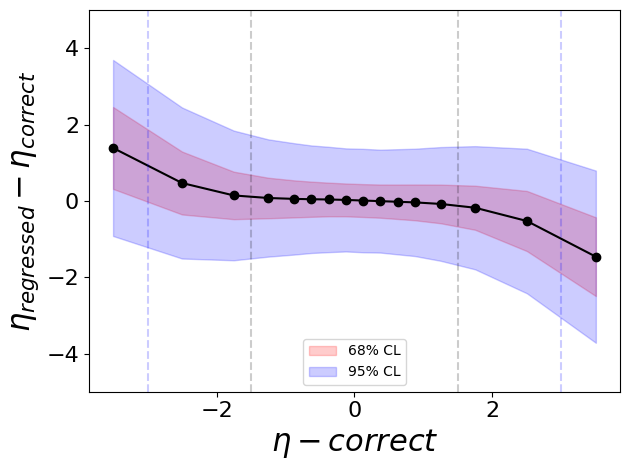

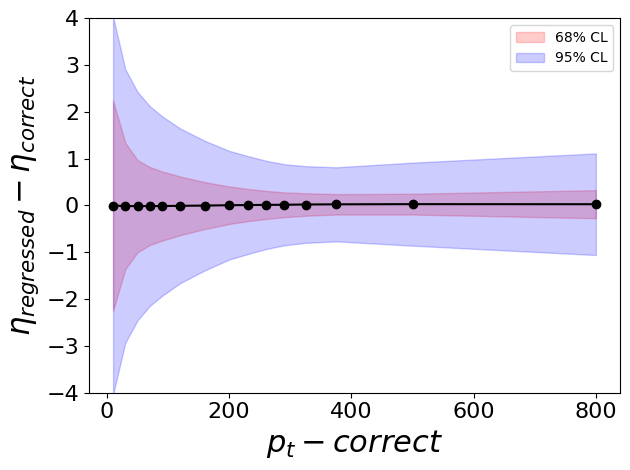

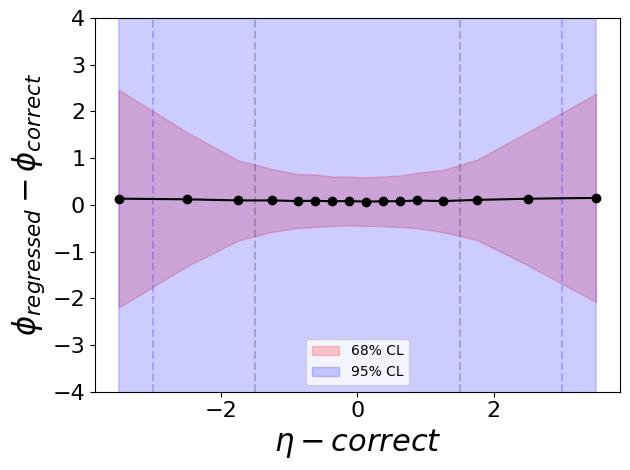

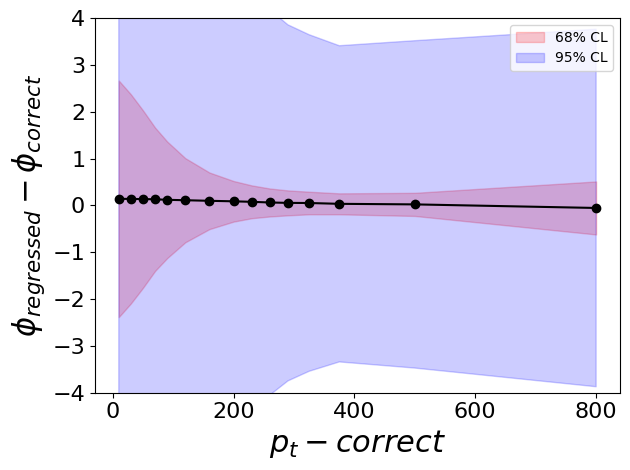

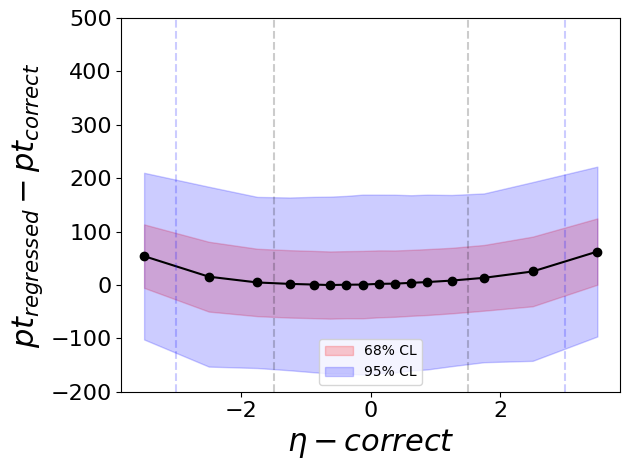

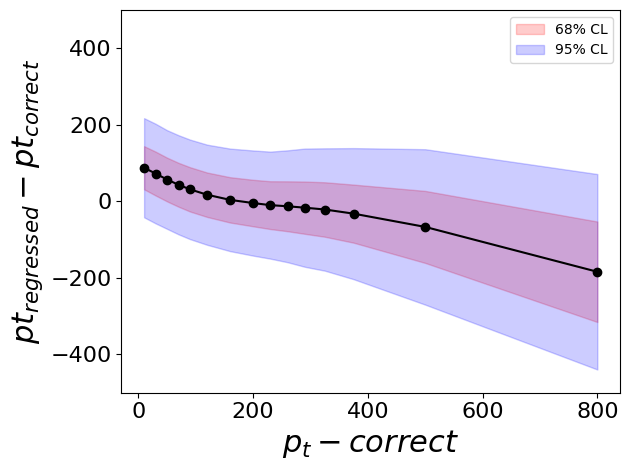

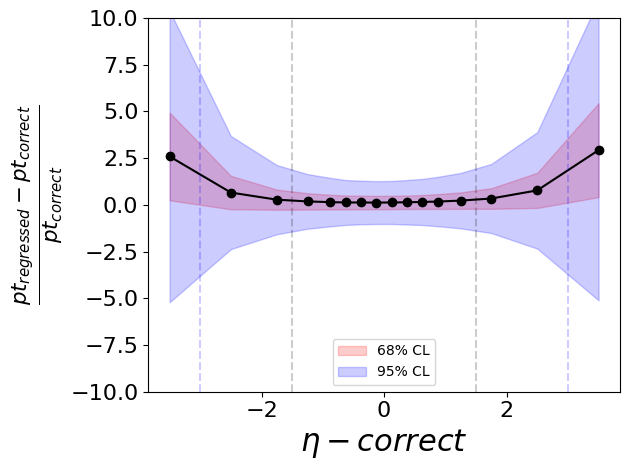

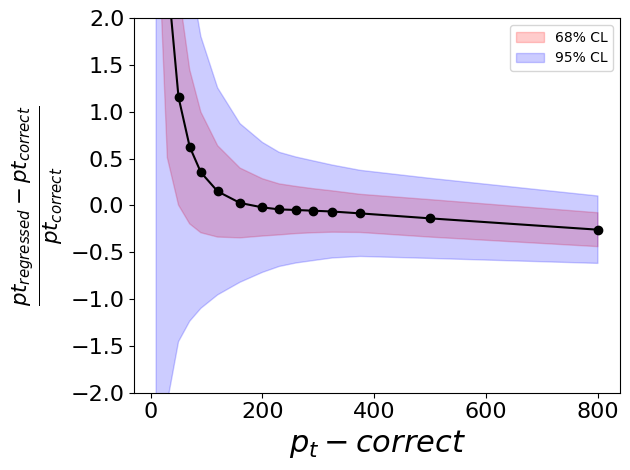

In [47]:
plot_regressionFactor(thad_regr.eta, thadCorrect.eta, thadCorrect.eta, matched=None,
                      intervalTargetVar=[-4,-3,-2,-1.5,-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.5,2,3,4],
                      limTarget=(-4, 4), bins=8, ylim=[-5,5], xname='$\eta-correct$',
                      yname='$\eta_{regressed} - \eta_{correct}$', eta=True,
                     nameDir=nameDir, nameFig='9.png')

plot_regressionFactor(thad_regr.eta, thadCorrect.eta, thadCorrect.pt, matched=None,
                      intervalTargetVar=[0,20,40,60,80,100,140,180,220,240,280,300,350,400,600,1000],
                      limTarget=(0, 1000), bins=20, ylim=[-4,4], xname='$p_t-correct$',
                      yname='$\eta_{regressed} - \eta_{correct}$',
                     nameDir=nameDir, nameFig='10.png')

plot_regressionFactor(thad_regr.phi, thadCorrect.phi, thadCorrect.eta, matched=None,
                      intervalTargetVar=[-4,-3,-2,-1.5,-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.5,2,3,4],
                      limTarget=(-4, 4), bins=8, ylim=[-4,4], xname='$\eta-correct$',
                      yname='$\phi_{regressed} - \phi_{correct}$', eta=True,
                     nameDir=nameDir, nameFig='11.png')

plot_regressionFactor(thad_regr.phi, thadCorrect.phi, thadCorrect.pt, matched=None,
                      limTarget=(0, 1000), bins=20, ylim=[-4,4], xname='$p_t-correct$',
                      intervalTargetVar=[0,20,40,60,80,100,140,180,220,240,280,300,350,400,600,1000],
                      yname='$\phi_{regressed} - \phi_{correct}$',
                     nameDir=nameDir, nameFig='12.png')

plot_regressionFactor(thad_regr.pt, thadCorrect.pt, thadCorrect.eta, matched=None,
                      intervalTargetVar=[-4,-3,-2,-1.5,-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.5,2,3,4],
                      limTarget=(-4, 4), bins=8, ylim=[-200,500], xname='$\eta-correct$',
                      yname='$pt_{regressed} - pt_{correct}$', eta=True,
                     nameDir=nameDir, nameFig='13.png')

plot_regressionFactor(thad_regr.pt, thadCorrect.pt, thadCorrect.pt, matched=None,
                      intervalTargetVar=[0,20,40,60,80,100,140,180,220,240,280,300,350,400,600,1000],
                      limTarget=(0, 1000), bins=20, ylim=[-500,500], xname='$p_t-correct$',
                      yname='$pt_{regressed} - pt_{correct}$',
                     nameDir=nameDir, nameFig='14.png')

plot_regressionFactor(thad_regr.pt, thadCorrect.pt, thadCorrect.eta, matched=None,
                      intervalTargetVar=[-4,-3,-2,-1.5,-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.5,2,3,4],
                      limTarget=(-4, 4), bins=8, ylim=[-10,10], xname='$\eta-correct$',
                      yname=r'$\frac{pt_{regressed} - pt_{correct}}{pt_{correct}}$', eta=True, ratio=True,
                     nameDir=nameDir, nameFig='15.png')

plot_regressionFactor(thad_regr.pt, thadCorrect.pt, thadCorrect.pt, matched=None,
                      intervalTargetVar=[0,20,40,60,80,100,140,180,220,240,280,300,350,400,600,1000],
                      limTarget=(0, 1000), bins=20, ylim=[-2,2], xname='$p_t-correct$',
                      yname=r'$\frac{pt_{regressed} - pt_{correct}}{pt_{correct}}$', ratio=True,
                     nameDir=nameDir, nameFig='16.png')

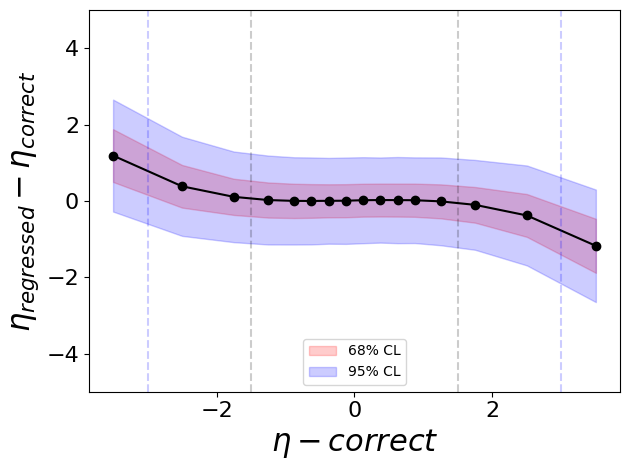

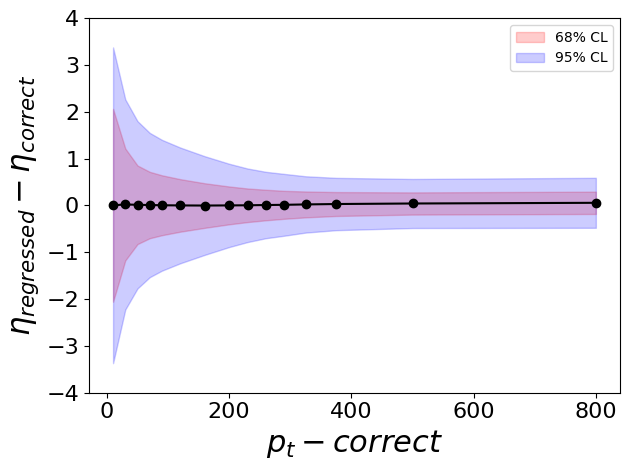

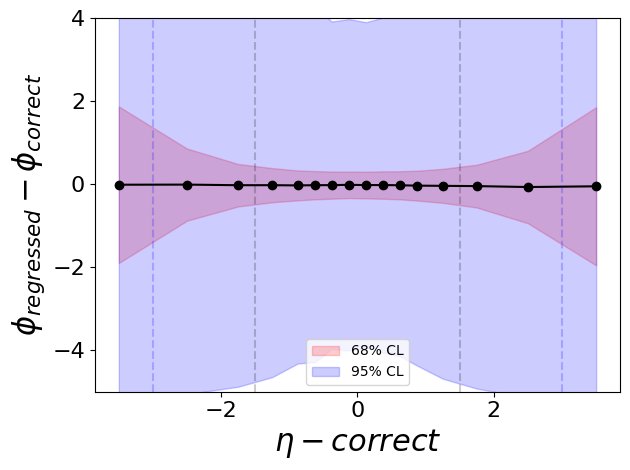

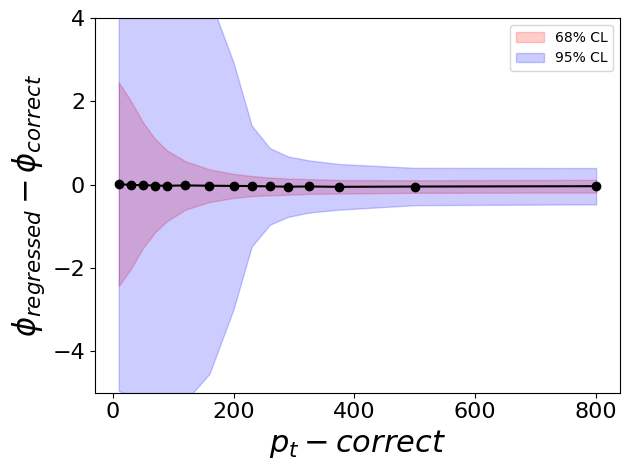

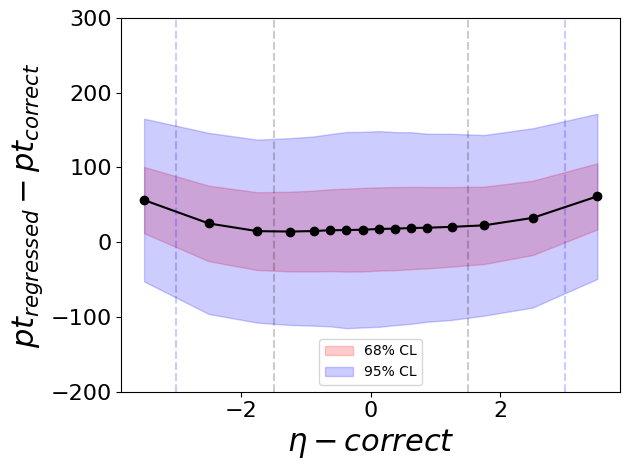

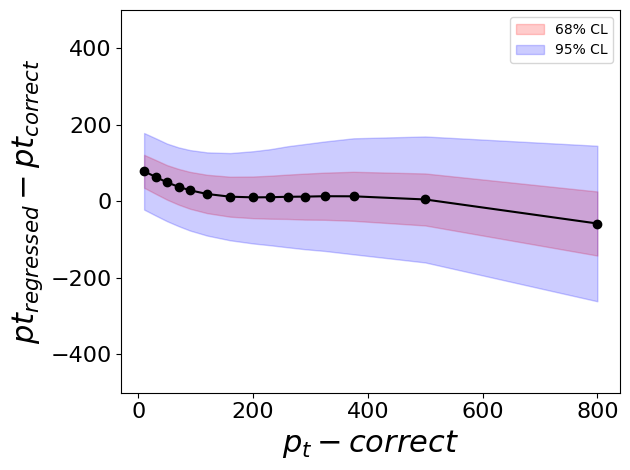

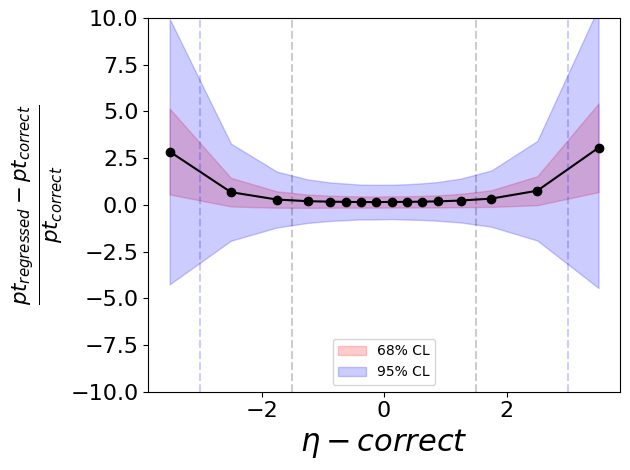

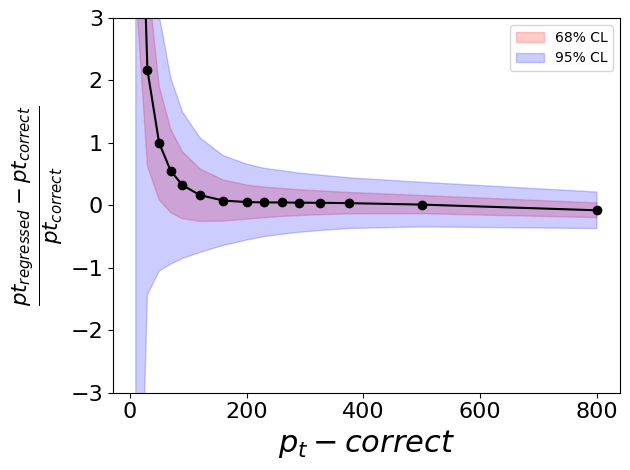

In [69]:
plot_regressionFactor(tlep_regr.eta, tlepCorrect.eta, tlepCorrect.eta, matched=None,
                      intervalTargetVar=[-4,-3,-2,-1.5,-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.5,2,3,4],
                      limTarget=(-4, 4), bins=8, ylim=[-5,5], xname='$\eta-correct$',
                      yname='$\eta_{regressed} - \eta_{correct}$', eta=True,
                     nameDir=nameDir, nameFig='17.png')

plot_regressionFactor(tlep_regr.eta, tlepCorrect.eta, tlepCorrect.pt, matched=None,
                      intervalTargetVar=[0,20,40,60,80,100,140,180,220,240,280,300,350,400,600,1000],
                      limTarget=(0, 1000), bins=20, ylim=[-4,4], xname='$p_t-correct$',
                      yname='$\eta_{regressed} - \eta_{correct}$',
                     nameDir=nameDir, nameFig='18.png')

plot_regressionFactor(tlep_regr.phi, tlepCorrect.phi, tlepCorrect.eta, matched=None,
                      intervalTargetVar=[-4,-3,-2,-1.5,-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.5,2,3,4],
                      limTarget=(-4, 4), bins=8, ylim=[-5,4], xname='$\eta-correct$',
                      yname='$\phi_{regressed} - \phi_{correct}$', eta=True,
                     nameDir=nameDir, nameFig='19.png')

plot_regressionFactor(tlep_regr.phi, tlepCorrect.phi, tlepCorrect.pt, matched=None,
                      limTarget=(0, 1000), bins=20, ylim=[-5,4], xname='$p_t-correct$',
                      intervalTargetVar=[0,20,40,60,80,100,140,180,220,240,280,300,350,400,600,1000],
                      yname='$\phi_{regressed} - \phi_{correct}$',
                     nameDir=nameDir, nameFig='20.png')

plot_regressionFactor(tlep_regr.pt, tlepCorrect.pt, tlepCorrect.eta, matched=None,
                      intervalTargetVar=[-4,-3,-2,-1.5,-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.5,2,3,4],
                      limTarget=(-4, 4), bins=8, ylim=[-200,300], xname='$\eta-correct$',
                      yname='$pt_{regressed} - pt_{correct}$', eta=True,
                     nameDir=nameDir, nameFig='21.png')

plot_regressionFactor(tlep_regr.pt, tlepCorrect.pt, tlepCorrect.pt, matched=None,
                      intervalTargetVar=[0,20,40,60,80,100,140,180,220,240,280,300,350,400,600,1000],
                      limTarget=(0, 1000), bins=20, ylim=[-500,500], xname='$p_t-correct$',
                      yname='$pt_{regressed} - pt_{correct}$',
                     nameDir=nameDir, nameFig='22.png')

plot_regressionFactor(tlep_regr.pt, tlepCorrect.pt, tlepCorrect.eta, matched=None,
                      intervalTargetVar=[-4,-3,-2,-1.5,-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.5,2,3,4],
                      limTarget=(-4, 4), bins=8, ylim=[-10,10], xname='$\eta-correct$',
                      yname=r'$\frac{pt_{regressed} - pt_{correct}}{pt_{correct}}$', eta=True, ratio=True,
                     nameDir=nameDir, nameFig='23.png')

plot_regressionFactor(tlep_regr.pt, tlepCorrect.pt, tlepCorrect.pt, matched=None,
                      intervalTargetVar=[0,20,40,60,80,100,140,180,220,240,280,300,350,400,600,1000],
                      limTarget=(0, 1000), bins=20, ylim=[-3,3], xname='$p_t-correct$',
                      yname=r'$\frac{pt_{regressed} - pt_{correct}}{pt_{correct}}$', ratio=True,
                     nameDir=nameDir, nameFig='24.png')

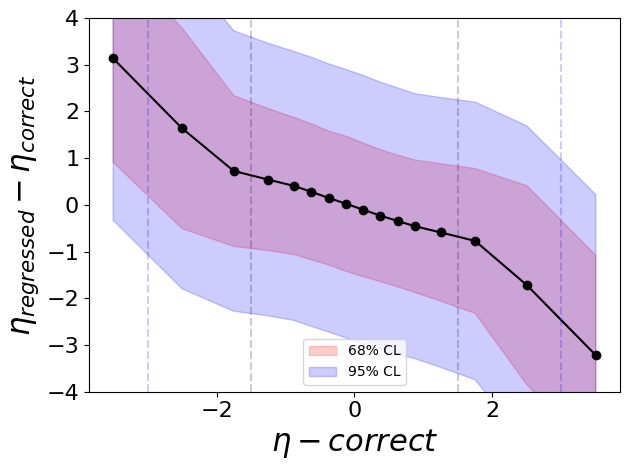

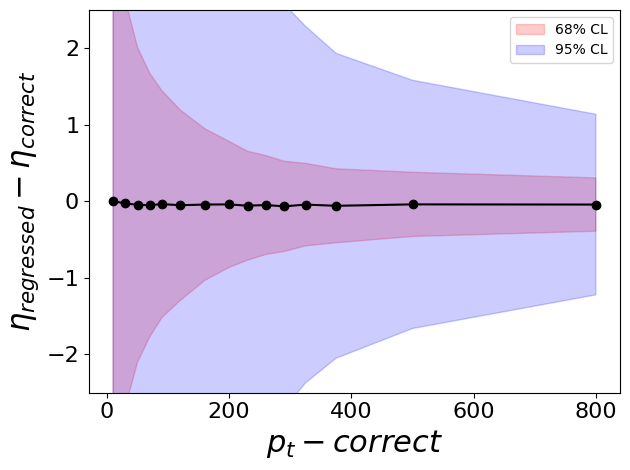

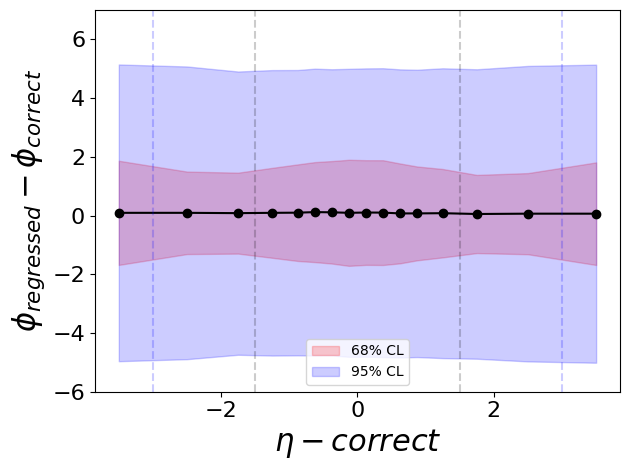

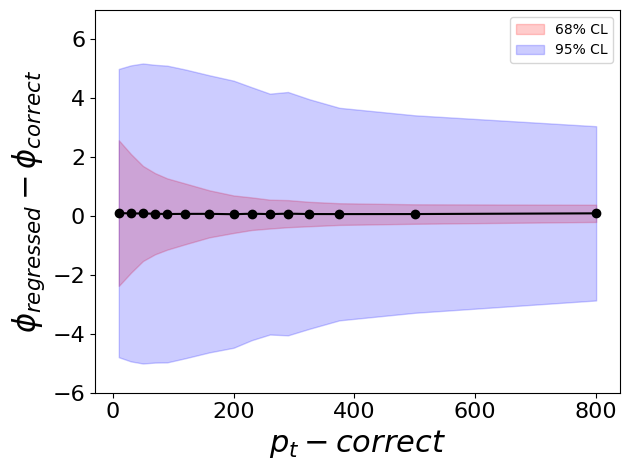

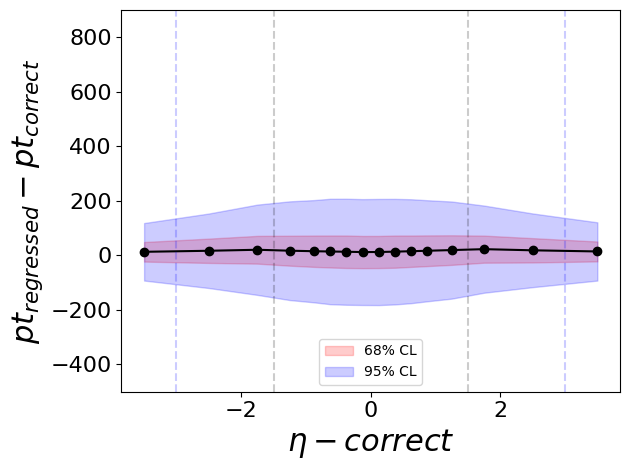

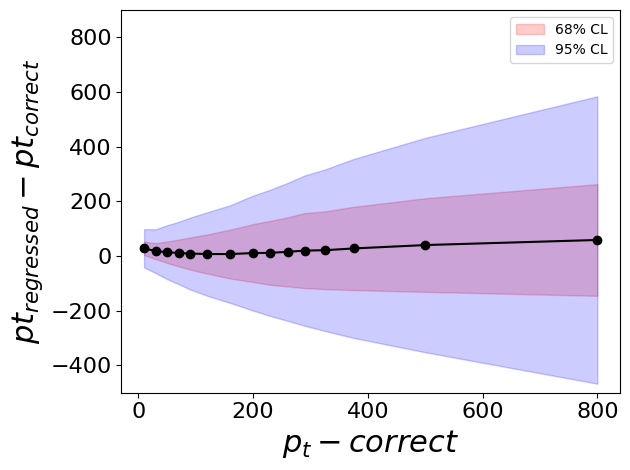

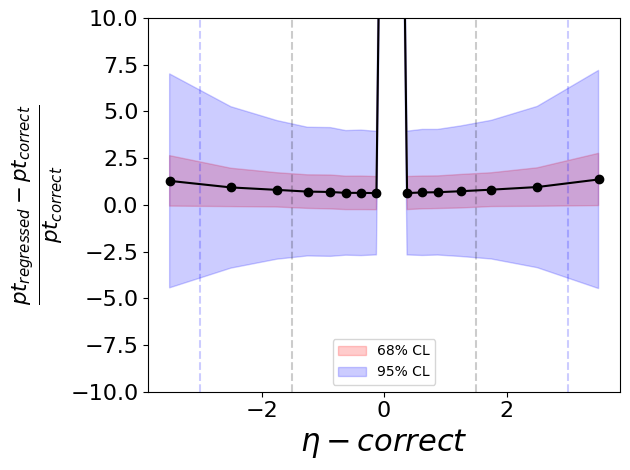

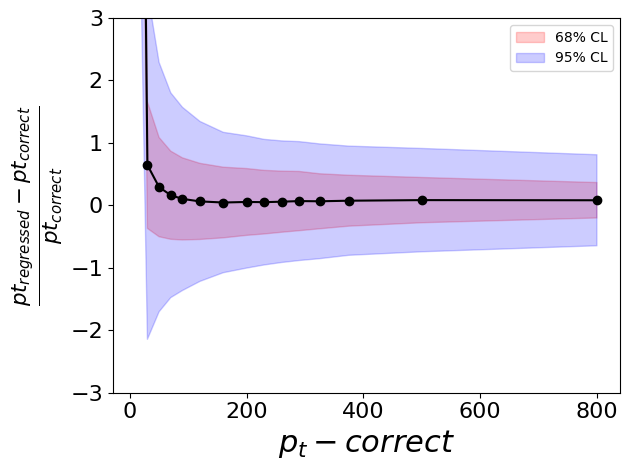

In [48]:
plot_regressionFactor(glISR_regr.eta, glISRCorrect.eta, glISRCorrect.eta, matched=None,
                      intervalTargetVar=[-4,-3,-2,-1.5,-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.5,2,3,4],
                      limTarget=(-4, 4), bins=8, ylim=[-4,4], xname='$\eta-correct$',
                      yname='$\eta_{regressed} - \eta_{correct}$', eta=True,
                     nameDir=nameDir, nameFig='25.png')

plot_regressionFactor(glISR_regr.eta, glISRCorrect.eta, glISRCorrect.pt, matched=None,
                      intervalTargetVar=[0,20,40,60,80,100,140,180,220,240,280,300,350,400,600,1000],
                      limTarget=(0, 1000), bins=20, ylim=[-2.5,2.5], xname='$p_t-correct$',
                      yname='$\eta_{regressed} - \eta_{correct}$',
                     nameDir=nameDir, nameFig='26.png')

plot_regressionFactor(glISR_regr.phi, glISRCorrect.phi, glISRCorrect.eta, matched=None,
                      intervalTargetVar=[-4,-3,-2,-1.5,-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.5,2,3,4],
                      limTarget=(-4, 4), bins=8, ylim=[-6,7], xname='$\eta-correct$',
                      yname='$\phi_{regressed} - \phi_{correct}$', eta=True,
                     nameDir=nameDir, nameFig='27.png')

plot_regressionFactor(glISR_regr.phi, glISRCorrect.phi, glISRCorrect.pt, matched=None,
                      limTarget=(0, 1000), bins=20, ylim=[-6,7], xname='$p_t-correct$',
                      intervalTargetVar=[0,20,40,60,80,100,140,180,220,240,280,300,350,400,600,1000],
                      yname='$\phi_{regressed} - \phi_{correct}$',
                     nameDir=nameDir, nameFig='28.png')

plot_regressionFactor(glISR_regr.pt, glISRCorrect.pt, glISRCorrect.eta, matched=None,
                      intervalTargetVar=[-4,-3,-2,-1.5,-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.5,2,3,4],
                      limTarget=(-4, 4), bins=8, ylim=[-500,900], xname='$\eta-correct$',
                      yname='$pt_{regressed} - pt_{correct}$', eta=True,
                     nameDir=nameDir, nameFig='29.png')

plot_regressionFactor(glISR_regr.pt, glISRCorrect.pt, glISRCorrect.pt, matched=None,
                      intervalTargetVar=[0,20,40,60,80,100,140,180,220,240,280,300,350,400,600,1000],
                      limTarget=(0, 1000), bins=20, ylim=[-500,900], xname='$p_t-correct$',
                      yname='$pt_{regressed} - pt_{correct}$',
                     nameDir=nameDir, nameFig='30.png')

plot_regressionFactor(glISR_regr.pt, glISRCorrect.pt, glISRCorrect.eta, matched=None,
                      intervalTargetVar=[-4,-3,-2,-1.5,-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.5,2,3,4],
                      limTarget=(-4, 4), bins=8, ylim=[-10,10], xname='$\eta-correct$',
                      yname=r'$\frac{pt_{regressed} - pt_{correct}}{pt_{correct}}$', eta=True, ratio=True,
                     nameDir=nameDir, nameFig='31.png')

plot_regressionFactor(glISR_regr.pt, glISRCorrect.pt, glISRCorrect.pt, matched=None,
                      intervalTargetVar=[0,20,40,60,80,100,140,180,220,240,280,300,350,400,600,1000],
                      limTarget=(0, 1000), bins=20, ylim=[-3,3], xname='$p_t-correct$',
                      yname=r'$\frac{pt_{regressed} - pt_{correct}}{pt_{correct}}$', ratio=True,
                     nameDir=nameDir, nameFig='32.png')

In [49]:
def plot_var2d(higgs_var1, higgs_var2, thad_var1, thad_var2, tlep_var1, tlep_var2,
             ISR_var1, ISR_var2, name1, name2, nameFig, start1=0, stop1=1000, start2=0, stop2=1000, bins1=100, bins2=100,
             higgs_mask=1, thad_mask=1, tlep_mask=1, ISR_mask=1, neg_Mask=False, log=False, name='da', nameunit=''):
        
        
        if neg_Mask:
            higgs_mask = np.logical_not(higgs_mask)
            thad_mask = np.logical_not(thad_mask)
            tlep_mask = np.logical_not(tlep_mask)
            ISR_mask = np.logical_not(ISR_mask)

        # Quick construction, no other imports needed:
        hist2d_var_higgs = (
          Hist.new
          .Reg(bins=bins1, start=start1, stop=stop1, name=name1, label=name1)
          .Reg(bins=bins2, start=start2, stop=stop2, name=name2, label=name2)
          .Double())

        hist2d_var_thad = (
          Hist.new
          .Reg(bins=bins1, start=start1, stop=stop1, name=name1, label=name1)
          .Reg(bins=bins2, start=start2, stop=stop2, name=name2, label=name2)
          .Double())

        hist2d_var_tlep = (
          Hist.new
          .Reg(bins=bins1, start=start1, stop=stop1, name=name1, label=name1)
          .Reg(bins=bins2, start=start2, stop=stop2, name=name2, label=name2)
          .Double())

        hist2d_var_ISR = (
          Hist.new
          .Reg(bins=bins1, start=start1, stop=stop1, name=name1, label=name1)
          .Reg(bins=bins2, start=start2, stop=stop2, name=name2, label=name2)
          .Double())

        
        hist2d_var_higgs.fill(higgs_var1[higgs_mask],
                            higgs_var2[higgs_mask])

        hist2d_var_thad.fill(thad_var1[thad_mask],
                            thad_var2[thad_mask])

        hist2d_var_tlep.fill(tlep_var1[tlep_mask],
                            tlep_var2[tlep_mask])

        hist2d_var_ISR.fill(ISR_var1[ISR_mask],
                            ISR_var2[ISR_mask])

        colormap='viridis'
        my_viridis = mpl.colormaps[colormap].with_extremes(under="white")
        
        fontsize = 20
        labelsize=14
        labels = ['higgs', 'thad', 'tlep', 'ISR']
        hist2d_list = [hist2d_var_higgs, hist2d_var_thad, hist2d_var_tlep, hist2d_var_ISR]
        
        
        fig, axs = plt.subplots(1, 4, figsize=(16, 6))

        if log:
            for i in range(4):
                w, x, y = hist2d_list[i].to_numpy()
                mesh = axs[i].pcolormesh(x, y, w.T, cmap=my_viridis, norm=mpl.colors.LogNorm(vmin=1))
                axs[i].set_xlabel(f"{name}-correct {nameunit}", fontsize=fontsize)
                axs[i].set_ylabel(f"{name}-regressed {nameunit}", fontsize=fontsize)
                axs[i].set_title(f"{labels[i]}", fontsize=fontsize)
                axs[i].tick_params(axis='both', which='major', labelsize=labelsize)
                cbar = fig.colorbar(mesh)
                cbar.ax.tick_params(labelsize=labelsize)
                plt.tight_layout()

        else:
            for i in range(4):
                w, x, y = hist2d_list[i].to_numpy()
                mesh = axs[i].pcolormesh(x, y, w.T, cmap=my_viridis, vmin=1)
                axs[i].set_xlabel(f"{name}-correct {nameunit}", fontsize=fontsize)
                axs[i].set_ylabel(f"{name}-regressed {nameunit}", fontsize=fontsize)
                axs[i].set_title(f"{labels[i]}", fontsize=fontsize)
                axs[i].tick_params(axis='both', which='major', labelsize=labelsize)
                cbar = fig.colorbar(mesh)
                cbar.ax.tick_params(labelsize=labelsize)
                plt.tight_layout()

In [50]:
all_mask = higgsCorrect.pt > 0

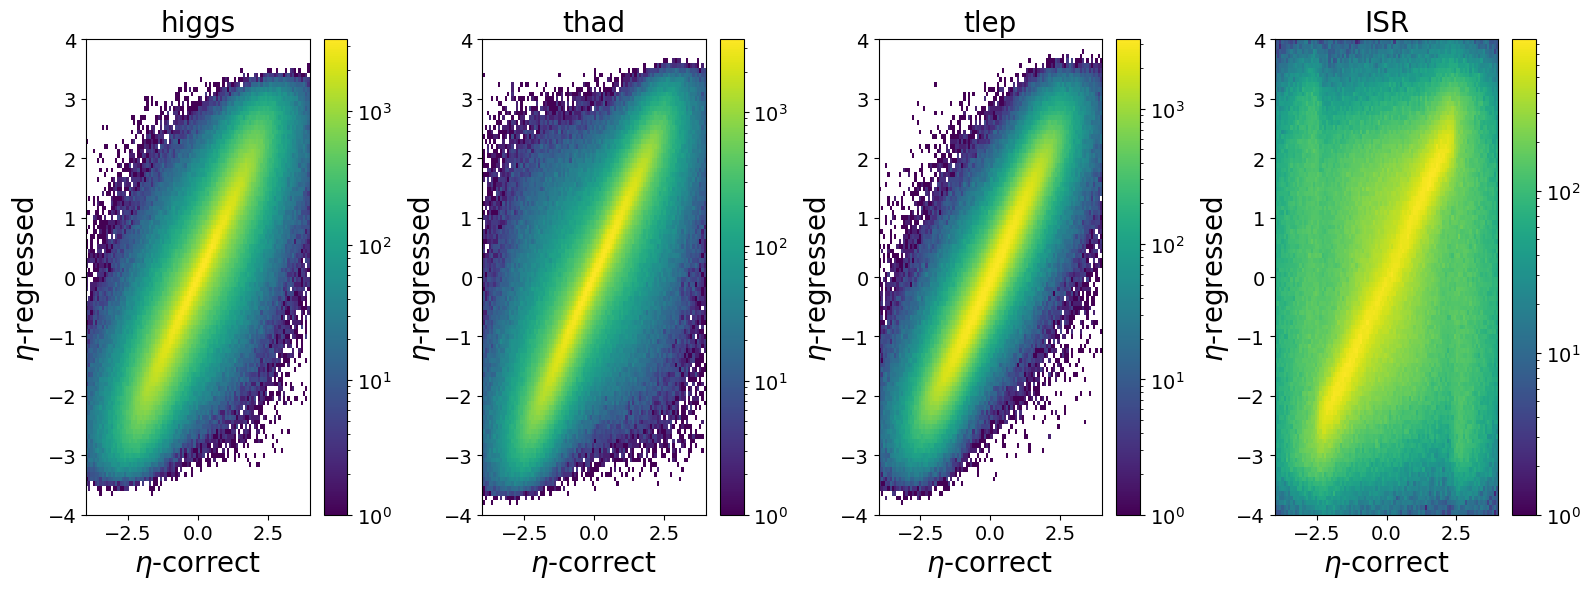

In [51]:
plot_var2d(higgs_var1=higgsCorrect.eta, higgs_var2=higgs_regr.eta,
           thad_var1=thadCorrect.eta, thad_var2=thad_regr.eta,
           tlep_var1=tlepCorrect.eta, tlep_var2=tlep_regr.eta,
           ISR_var1=glISRCorrect.eta, ISR_var2=glISR_regr.eta,
           name1='$eta-correct$', name2='$eta-regressed$', nameFig='29.png', 
           start1=-4, stop1=4, start2=-4, stop2=4, bins1=100, bins2=100,
           higgs_mask=all_mask, thad_mask=all_mask, tlep_mask=all_mask, ISR_mask=all_mask,
           neg_Mask=False, log=True, name='$\eta$')

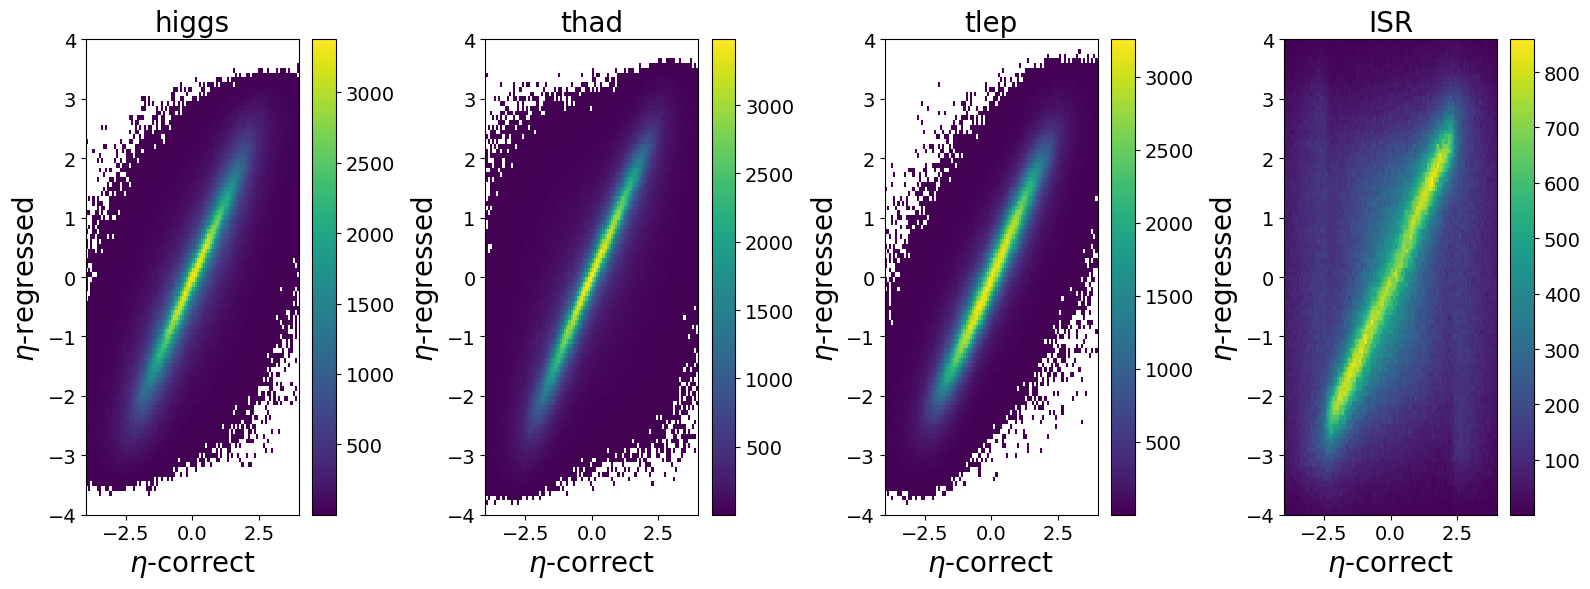

In [52]:
plot_var2d(higgs_var1=higgsCorrect.eta, higgs_var2=higgs_regr.eta,
           thad_var1=thadCorrect.eta, thad_var2=thad_regr.eta,
           tlep_var1=tlepCorrect.eta, tlep_var2=tlep_regr.eta,
           ISR_var1=glISRCorrect.eta, ISR_var2=glISR_regr.eta,
           name1='$eta-correct$', name2='$eta-regressed$', nameFig='29.png', 
           start1=-4, stop1=4, start2=-4, stop2=4, bins1=100, bins2=100,
           higgs_mask=all_mask, thad_mask=all_mask, tlep_mask=all_mask, ISR_mask=all_mask,
           neg_Mask=False, log=False, name='$\eta$')

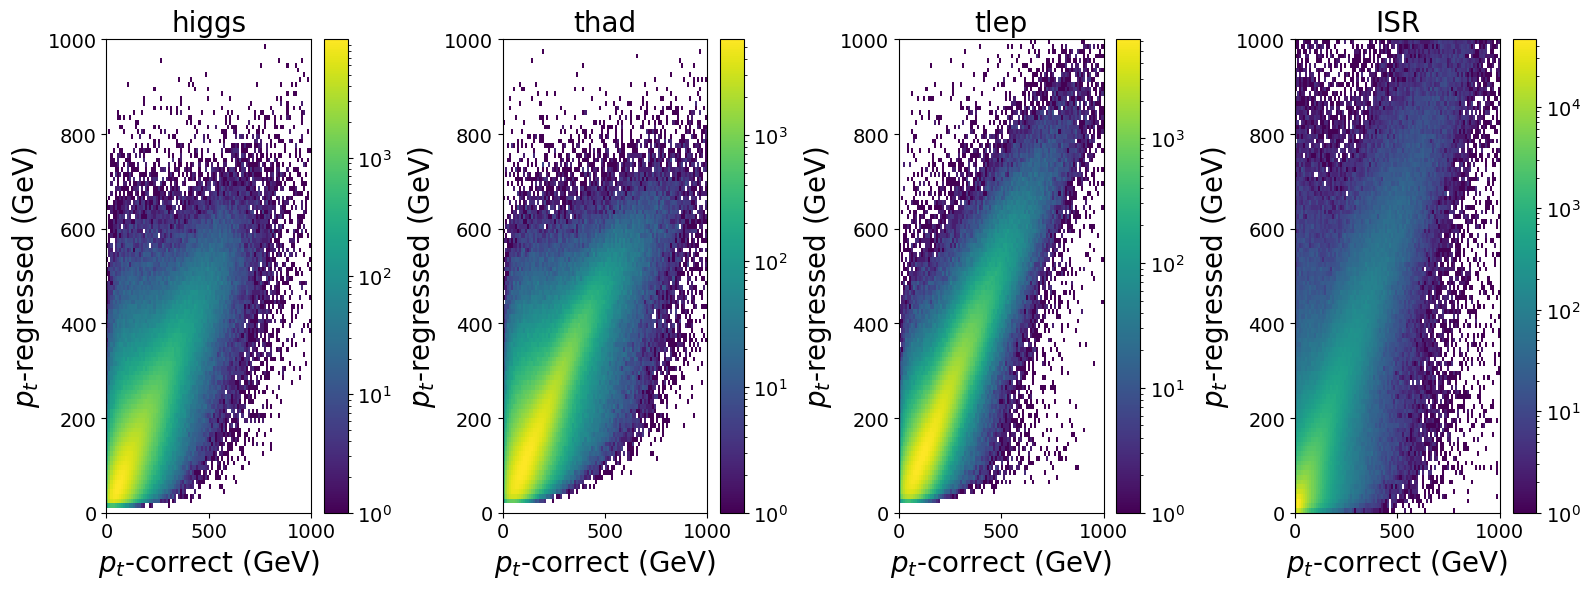

In [53]:
plot_var2d(higgs_var1=higgsCorrect.pt, higgs_var2=higgs_regr.pt,
           thad_var1=thadCorrect.pt, thad_var2=thad_regr.pt,
           tlep_var1=tlepCorrect.pt, tlep_var2=tlep_regr.pt,
           ISR_var1=glISRCorrect.pt, ISR_var2=glISR_regr.pt,
           name1='$eta-correct$', name2='$eta-regressed$', nameFig='29.png', 
           start1=0, stop1=1000, start2=0, stop2=1000, bins1=100, bins2=100,
           higgs_mask=all_mask, thad_mask=all_mask, tlep_mask=all_mask, ISR_mask=all_mask,
           neg_Mask=False, log=True, name='$p_t$', nameunit='(GeV)')

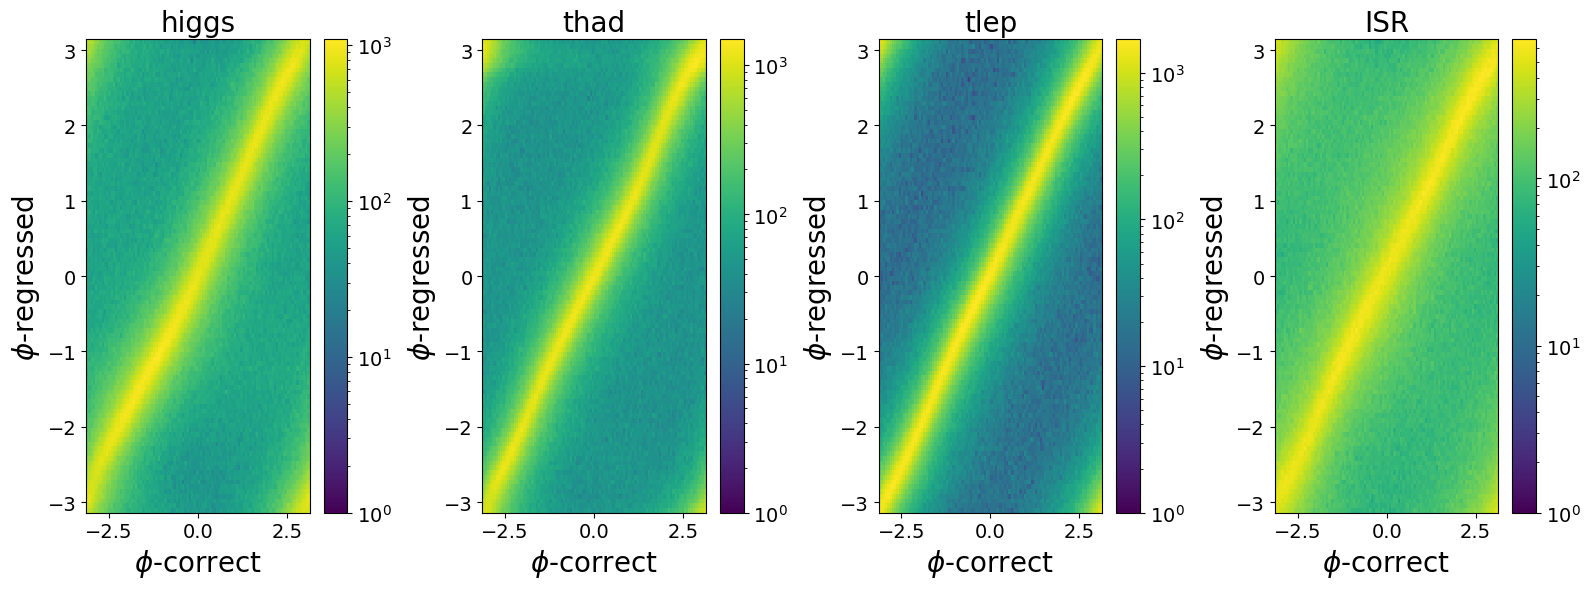

In [54]:
plot_var2d(higgs_var1=higgsCorrect.phi, higgs_var2=higgs_regr.phi,
           thad_var1=thadCorrect.phi, thad_var2=thad_regr.phi,
           tlep_var1=tlepCorrect.phi, tlep_var2=tlep_regr.phi,
           ISR_var1=glISRCorrect.phi, ISR_var2=glISR_regr.phi,
           name1='$eta-correct$', name2='$eta-regressed$', nameFig='29.png', 
           start1=-pi, stop1=pi, start2=-pi, stop2=pi, bins1=100, bins2=100,
           higgs_mask=all_mask, thad_mask=all_mask, tlep_mask=all_mask, ISR_mask=all_mask,
           neg_Mask=False, log=True, name='$\phi$')

# Using Boost from reco data

In [20]:
x1 = (data_boostReco[:, 0] + data_boostReco[:, 3]) / E_CM
x2 = (data_boostReco[:, 0] - data_boostReco[:, 3]) / E_CM
    
ps_regressed, detjinv_regressed = phasespace.get_ps_from_momenta(new_data_regressed, x1, x2, ensure_CM=True)
ps_regressed = torch.nan_to_num(ps_regressed, nan=-0.03)

In [21]:
print(ps_regressed.shape)

torch.Size([1414130, 10])


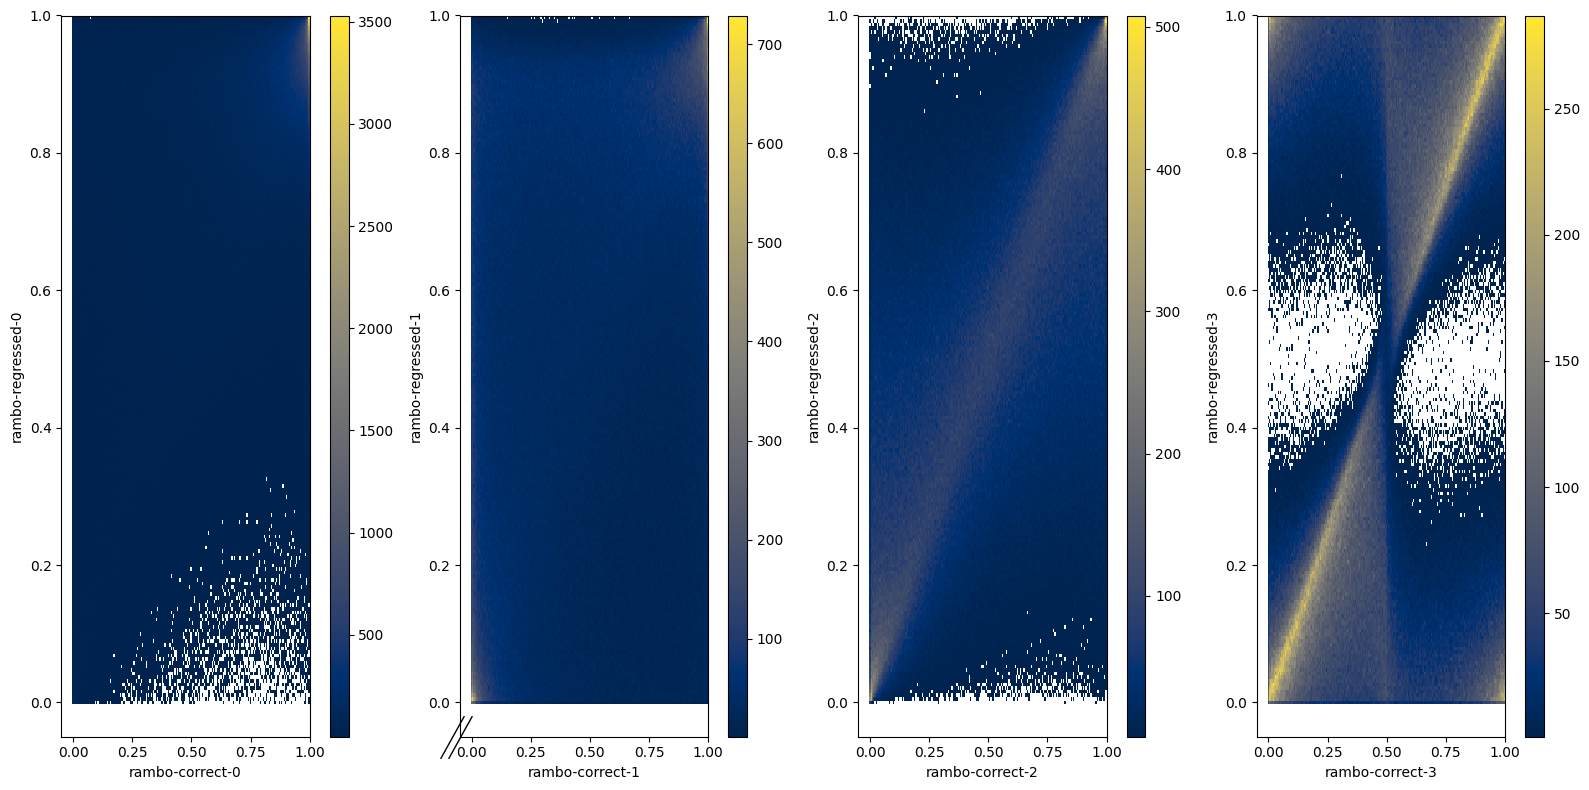

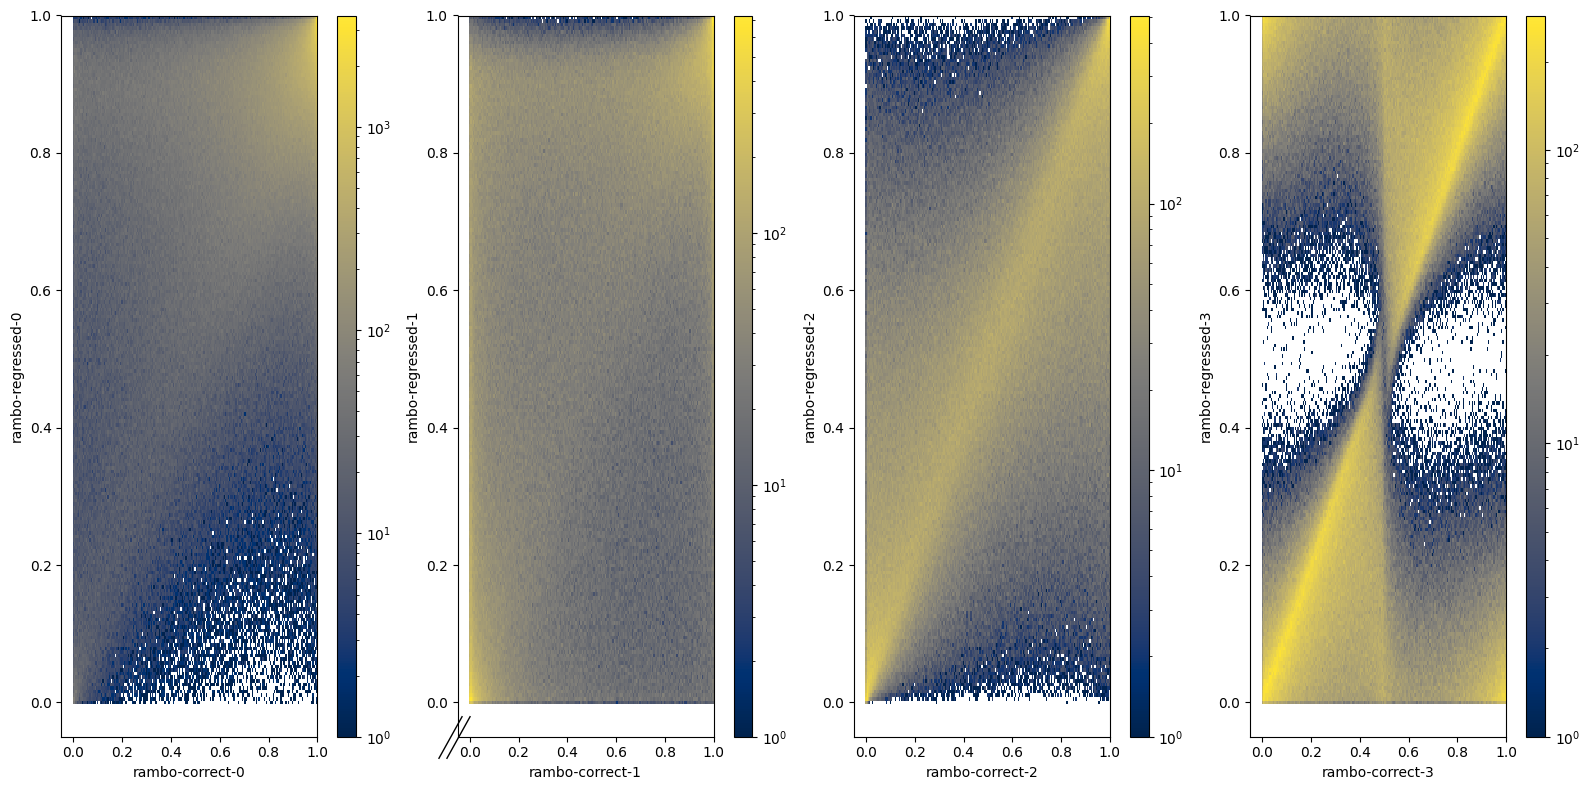

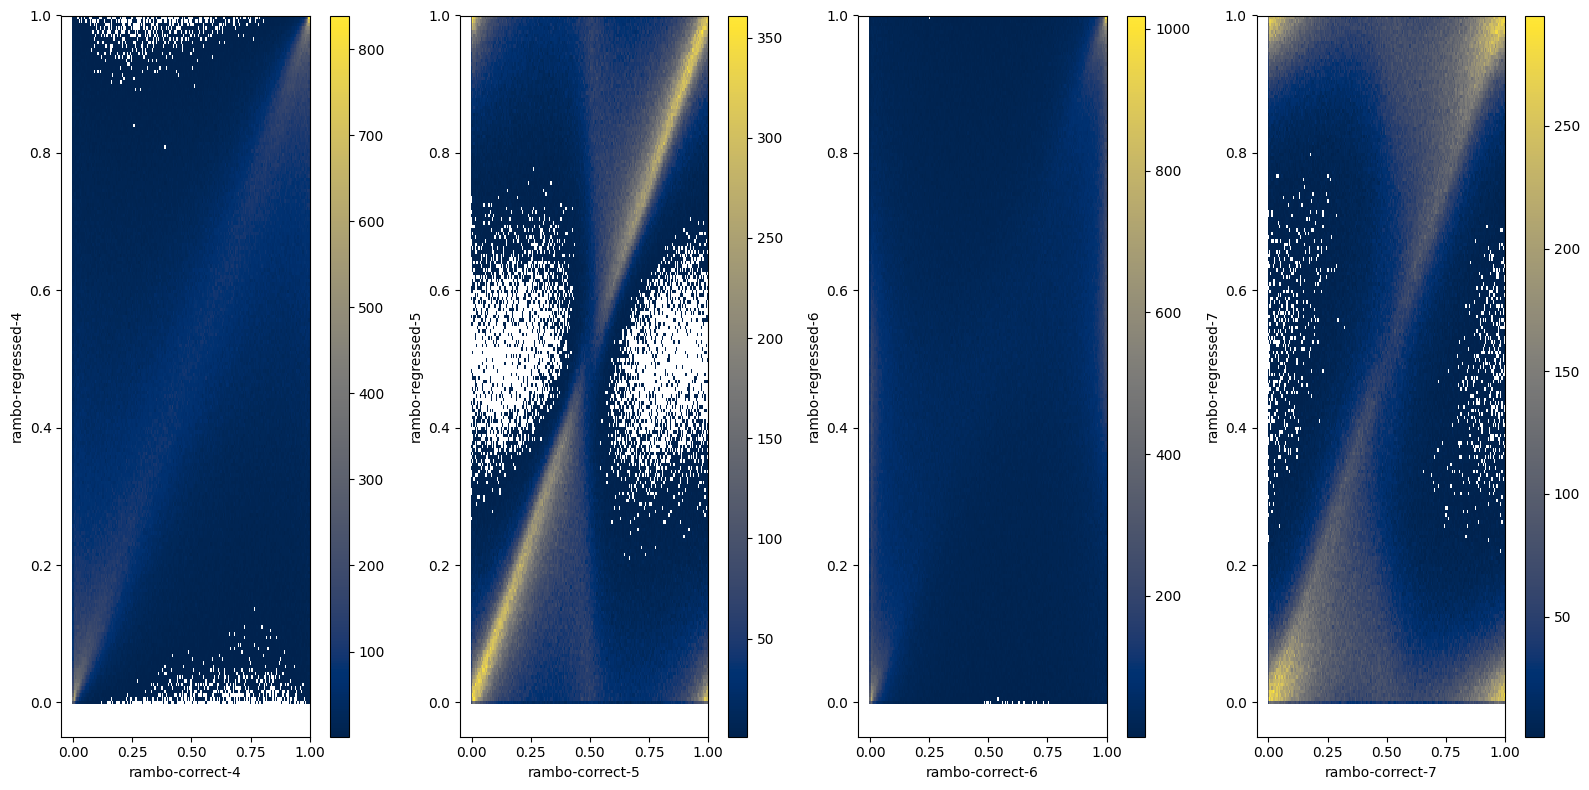

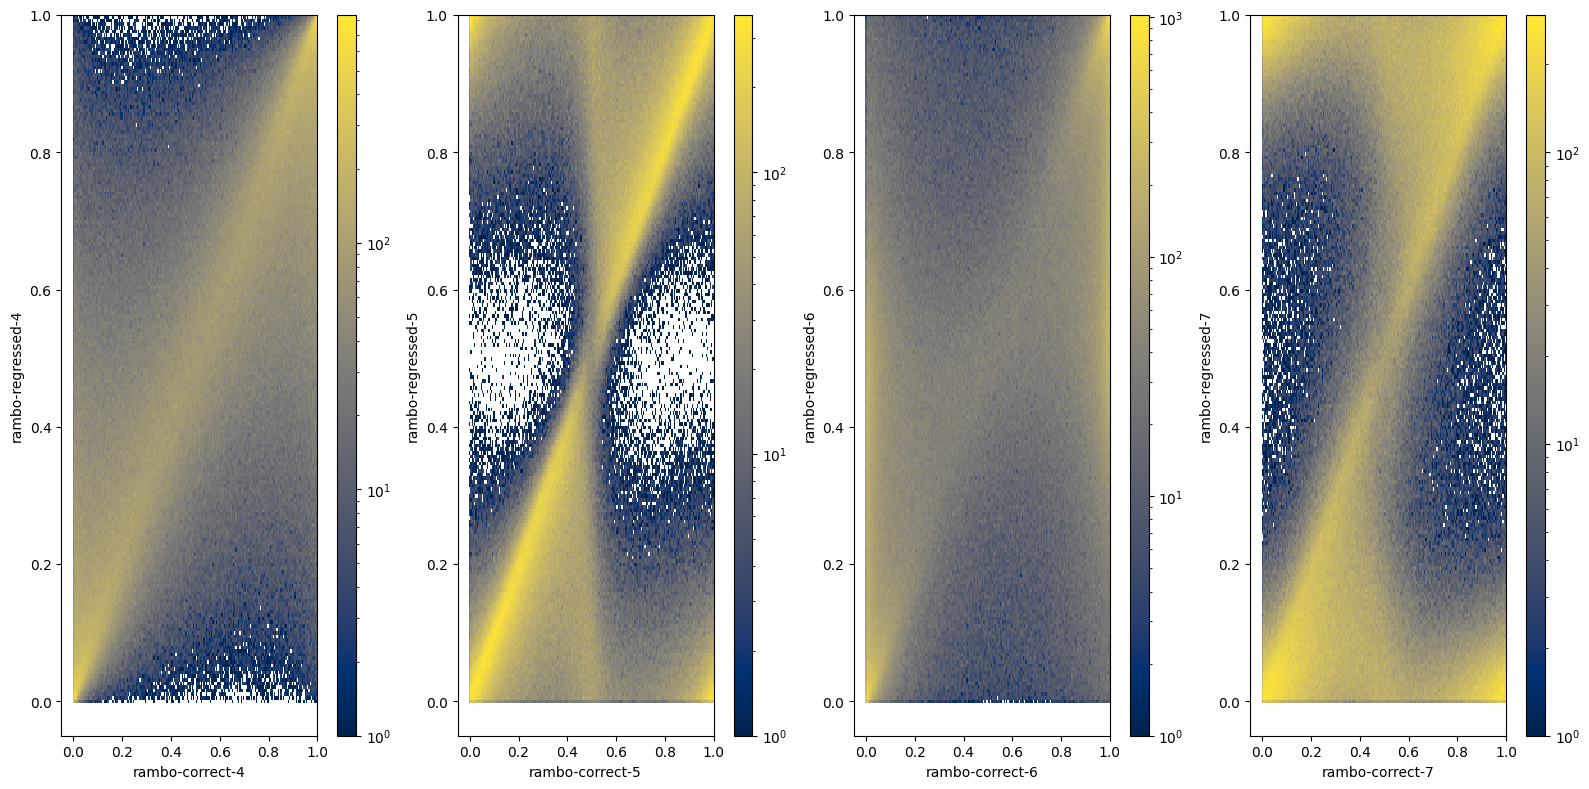

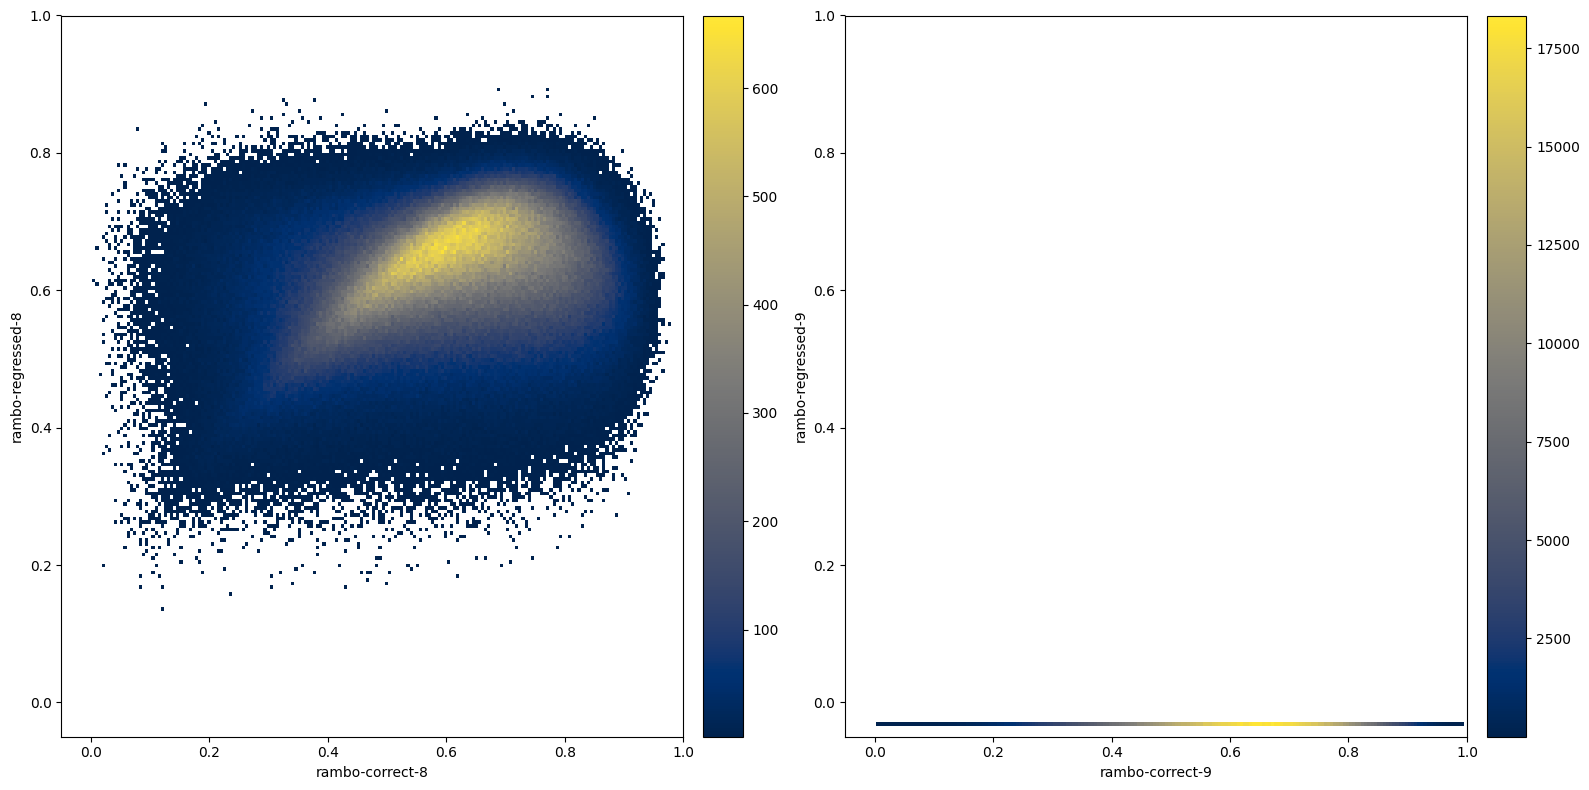

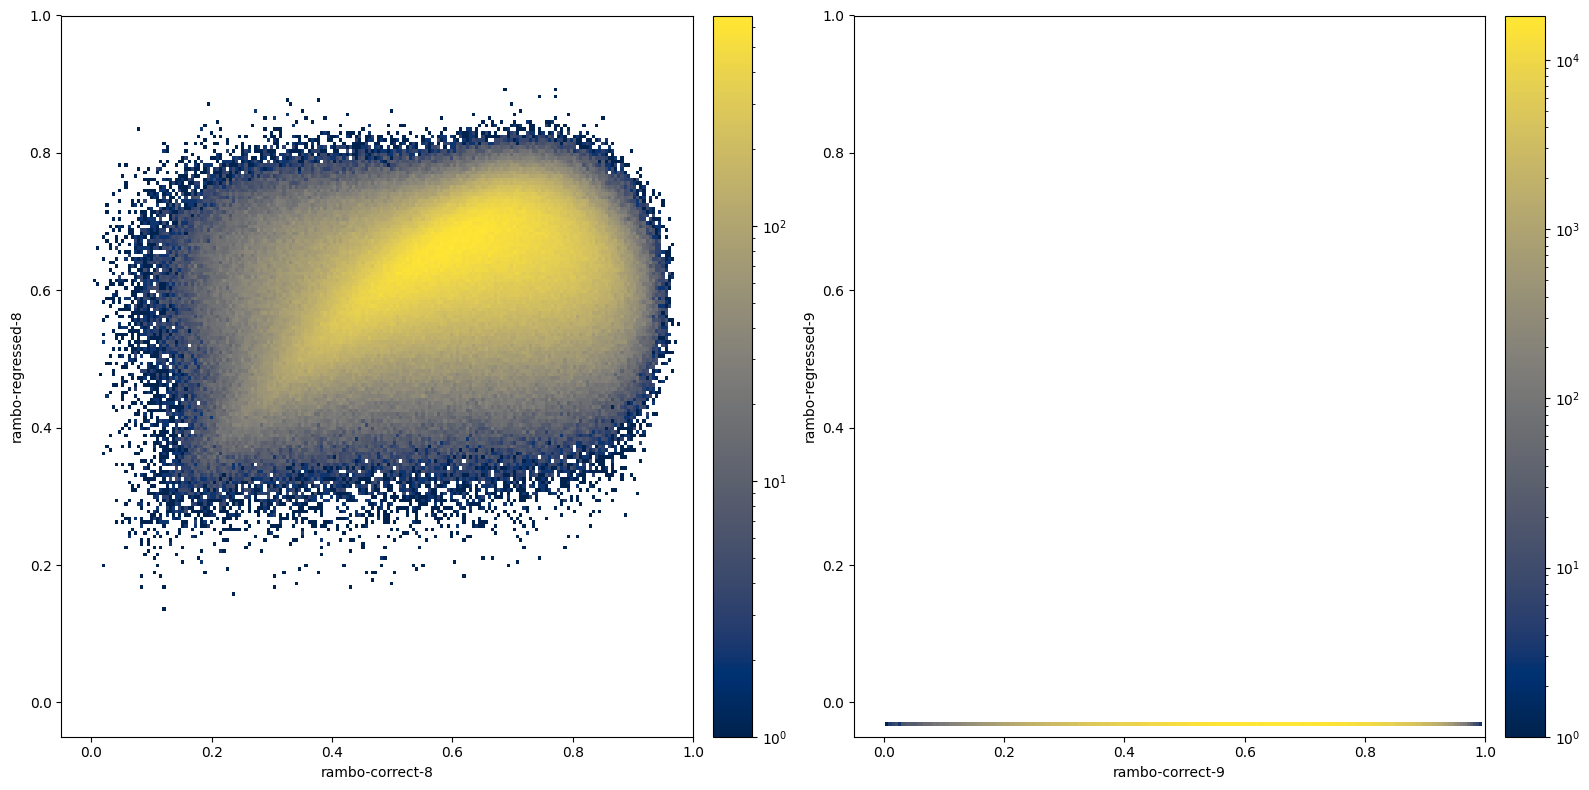

In [22]:
for i in range(3):
        numberFig = 61+2*i
        plots.plot_rambo(data_phasespace.detach().numpy(), ps_regressed.detach().numpy(),
                         nameFig=f'{numberFig}.png', typePlot=i, log=False)
        
        plots.plot_rambo(data_phasespace.detach().numpy(), ps_regressed.detach().numpy(),
                         nameFig=f'{numberFig+1}.png', typePlot=i, log=True)

# Using Boost from regressed data

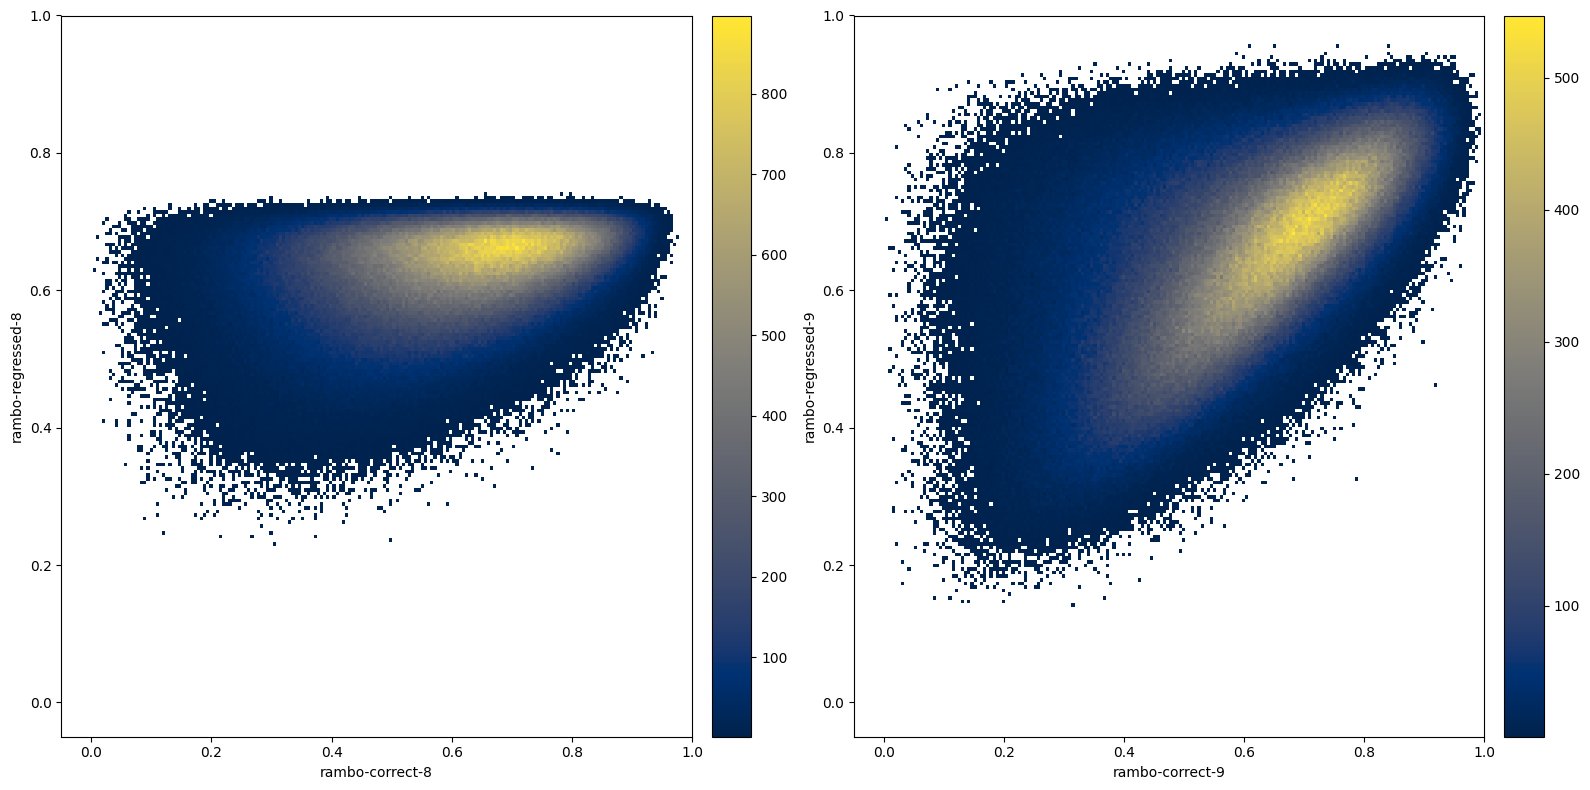

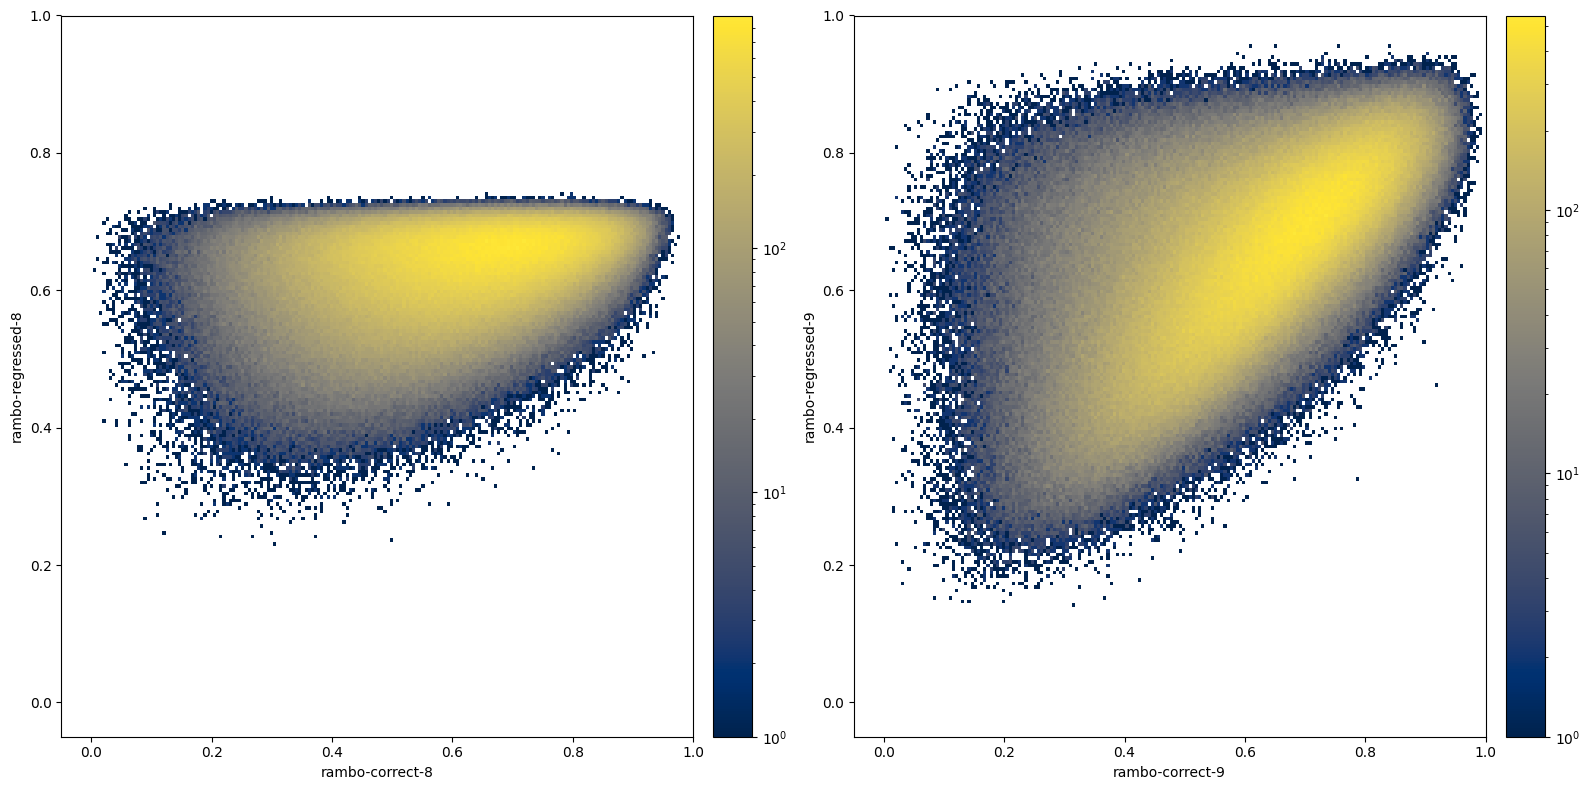

In [23]:
x1 = (boost_regressed[:, 0] + boost_regressed[:, 3]) / E_CM
x2 = (boost_regressed[:, 0] - boost_regressed[:, 3]) / E_CM
    
ps_regressed, detjinv_regressed = phasespace.get_ps_from_momenta(new_data_regressed, x1, x2, ensure_CM=True)
ps_regressed = torch.nan_to_num(ps_regressed, nan=-0.03)

numberFig = 67
# Here compute only x1/x2 (rest of plots look the same as above)
plots.plot_rambo(data_phasespace.detach().numpy(), ps_regressed.detach().numpy(),
                         nameFig=f'{numberFig}.png', typePlot=2, log=False)
        
plots.plot_rambo(data_phasespace.detach().numpy(), ps_regressed.detach().numpy(),
                         nameFig=f'{numberFig+1}.png', typePlot=2, log=True)